# *This file allows to generate all plots necessary for figures*

# **Useful packages and functions**

In [13]:
using DifferentialEquations, Plots, Polynomials, LaTeXStrings, ColorSchemes, DelimitedFiles, GraphPlot
using Statistics, StatsPlots, Random, ProgressMeter, Printf, LinearAlgebra, SimpleWeightedGraphs, Compose
include("FYON_2022_DA_kinetics.jl") # Loading of DA kinetics of gating variables
include("FYON_2022_DA_models.jl") # Loading of DA model
include("FYON_2022_DA_utils.jl") # Loading of some utils functions
include("FYON_2022_DA_gs_derivatives.jl") # Loading of X_inf derivatives
include("FYON_2022_DA_DIC.jl") # Loading of the DIC and compensation algorithm
include("FYON_2022_DA_neuromodulation.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [14]:
# Definition of simulation time (in ms)
const Tfinal = 10000
const tspan  = (0.0, Tfinal)

# Definition of reversal potential values (in mV), [Mg] and membrane capacitance
const VNa   = 60. # Sodium reversal potential
const VK    = -85. # Potassium reversal potential
const VCa   = 60. # Calcium reversal potential
const VNMDA = 0. # NMDA reversal potential
const Vleak = -50. # Reversal potential of leak channels
const Mg    = 1.4 # Mg concentration
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

struct eig
           values
           vectors
       end

default(fmt = :png);

# **Computing PCA of high frequency bursting neurons and homogeneous scaling using Monte Carlo (Figure 1)**

In [15]:
# Initializing some variables
Na_max = 60
Kd_max = 20
CaL_max = 0.1
CaN_max = 0.12
ERG_max = 0.25
leak_max = 0.02
N = 4e5
VV_maxmax = 58.5
VV_maxmin = 54
VV_minmin = -80.5
VV_minmax = -77.5
f_max = 1.95
f_min = 1.75
nb_channels = 6

g_all_MC = readdlm("./data/g_all_MC.dat")

# Initializing some variables
g_all_MC_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_MC_wout_NMDA[:, j] = deepcopy(g_all_MC[:, i])
    j = j + 1
end;

# **New figure 1**

In [16]:
names = [L"\bar{g}_\mathrm{Na}", L"\bar{g}_\mathrm{Kd}", L"\bar{g}_\mathrm{CaL}", 
         L"\bar{g}_\mathrm{CaN}", L"\bar{g}_\mathrm{ERG}", L"g_\mathrm{leak}"]
maxs = [Na_max, Kd_max, CaL_max, CaN_max, ERG_max, leak_max];

3×3 Matrix{Float64}:
 0.672703  NaN         NaN
 0.311166   -0.328074  NaN
 0.610253    0.211232    0.51359

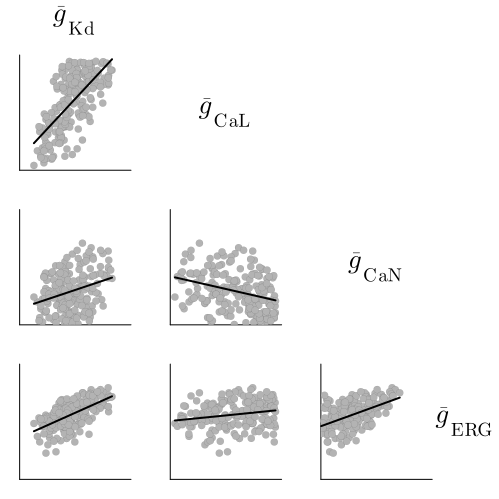

In [5]:
indices = [2, 3, 4, 5]
CC = scatter_matrix3x3(g_all_MC_wout_NMDA[:, indices], maxs[indices], :gray70, :none, names[indices], 
                       flag=0)
display(CC)
# savefig(CC, "./figures/DA_MC_matrix3x3_corr.pdf")

In [5]:
nb_edges = Int(nb_channels * (nb_channels-1) / 2)
r_values = zeros(nb_edges)
i1 = 1
i2 = 2
for i = 1 : nb_edges
    r_values[i] = cor(g_all_MC_wout_NMDA[:, i1], g_all_MC_wout_NMDA[:, i2])
    if abs(r_values[i]) < 1/nb_channels
        r_values[i] = 0.0
    end
    if i2 == i1 + 1
        i1 = 1
        i2 = i2 + 1
    else
        i1 = i1 + 1
    end
end

mysalmon = colorant"rgb(243, 124, 130)"
myblue = colorant"rgb(131, 174, 218)"
coloredges = [mysalmon for i = 1 : nb_edges]
for i = 1 : nb_edges
    if r_values[i] < 0
        coloredges[i] = myblue
    end
end

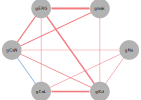

In [8]:
A = ones(nb_channels, nb_channels)
for i = 1 : nb_channels
    A[i, i] = 0
end
AA = convert(Array{Int64}, A)
GG = SimpleWeightedGraph(AA)
nodecolors=[RGB(0.7,0.7,0.7) for i=1:nb_channels]
nodelabel = ["gNa", "gKd", "gCaL", "gCaN", "gERG", "gleak"]

gdraw = gplot(GG, layout=circular_layout, nodefillc=nodecolors, nodelabel=nodelabel, NODESIZE=0.175,
              edgelinewidth=abs.(r_values), EDGELINEWIDTH=2, edgestrokec=coloredges)
display(gdraw)
# draw(SVG("./figures/DA_graph_corr.svg", 16cm, 16cm), gdraw);

# Cartoon homogeneous scaling

In [5]:
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1);

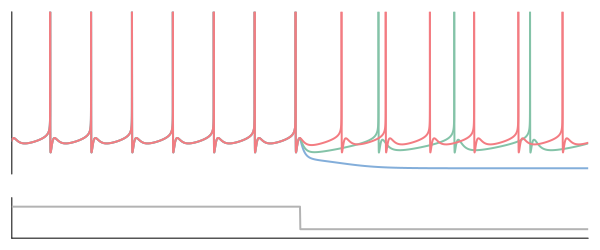

In [10]:
# is = [1, 24, 52]
const Tfinal = 10000
const tspan  = (0.0, Tfinal)
include("FYON_2022_DA_models.jl") # Loading of STG model
Iapp_fun(t) = 0. - 0.25 * (t>6000)
Iapp_fun2(t) = 0. - 0.28 * (t>6000)

i = 1
(gNa_HS, gKd_HS, gCaL_HS, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS) = g_all_MC[i, :]
p = [Iapp_fun, gNa_HS, gKd_HS, gCaL_HS, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS, C]

# Initial conditions
V0  = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_HS, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
idx = findall(sol.t .> 2000)
V_t_HS = sol[1, idx]
t_HS = sol.t[idx]
p1 = plot(t_HS, V_t_HS, color=myBlue, yguidefontsize=18, xguidefontsize=18, 
            legendfontsize=12, legend=false, 
           yticks=false, tickfontsize=15, grid=false, linewidth=2,
           xaxis=false, xticks=false, size=(600, 115))
ylims!((-100, 50))
xlims!((000, 10000))

# i = 24
# (gNa_HS, gKd_HS, gCaL_HS, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS) = g_all_MC[i, :]
r = 2
p = [Iapp_fun2, r*gNa_HS, r*gKd_HS, r*gCaL_HS, r*gCaN_HS, r*gERG_HS, r*gNMDA_HS, r*gleak_HS, r*C]

# Simulation
prob = ODEProblem(DA_ODE_HS, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
idx = findall(sol.t .> 2000)
V_t_HS = sol[1, idx]
t_HS = sol.t[idx]
plot!(t_HS, V_t_HS, color=myGreen, yguidefontsize=18, xguidefontsize=18, 
        legendfontsize=12, legend=false, 
           yticks=false, tickfontsize=15, grid=false, linewidth=2,
           xaxis=false, xticks=false, size=(600, 115))
ylims!((-100, 50))
xlims!((2000, 10000))

# i = 52
# (gNa_HS, gKd_HS, gCaL_HS, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS) = g_all_MC[i, :]
r = 10
p = [Iapp_fun, r*gNa_HS, r*gKd_HS, r*gCaL_HS, r*gCaN_HS, r*gERG_HS, r*gNMDA_HS, r*gleak_HS, r*C]

# Initial conditions
V0  = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_HS, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
idx = findall(sol.t .> 2000)
V_t_HS = sol[1, idx]
t_HS = sol.t[idx]
plot!(t_HS, V_t_HS, color=mySalmon, yguidefontsize=18, xguidefontsize=18, legendfontsize=12, 
          legend=false, 
           yticks=false, tickfontsize=15, grid=false, linewidth=2,
           xticks=false, xaxis=false, size=(600, 115))
ylims!((-100, 50))
xlims!((2000, 10000))



p4 = plot(t_HS, Iapp_fun.(t_HS), yguidefontsize=18, xguidefontsize=18, legendfontsize=12, legend=false, 
           yticks=false, tickfontsize=15, grid=false, xticks=false, size=(600, 55), linewidth=2,
         color=:gray70)
ylims!((-0.35, 0.1))
xlims!((2000, 10000))

l = @layout [
    a{1.0*w,0.8*h}
    b{1.0*w,0.2*h}
]

CC = plot(p1, p4, layout=l, size = (600, 250))
display(CC)

# CC = savefig("cartoon_HS_DA.pdf")

In [20]:
findall(g_all_MC[:, 4] .> 0.082)

1-element Vector{Int64}:
 33

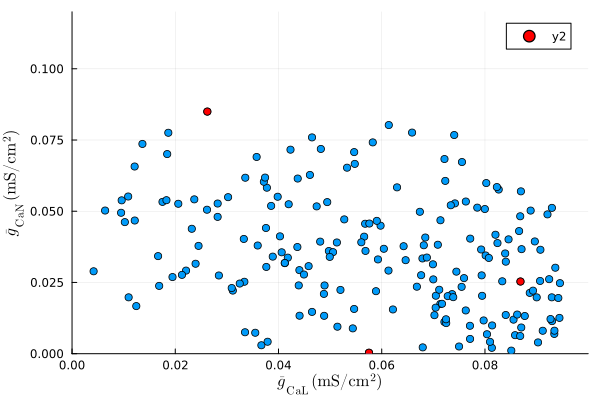

In [88]:
scatter(g_all_MC[:, 3], g_all_MC[:, 4], label="")
idx = [33, 111, 83]
scatter!(g_all_MC[idx, 3], g_all_MC[idx, 4], color=:red)
xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.1))
ylims!((0, 0.12))

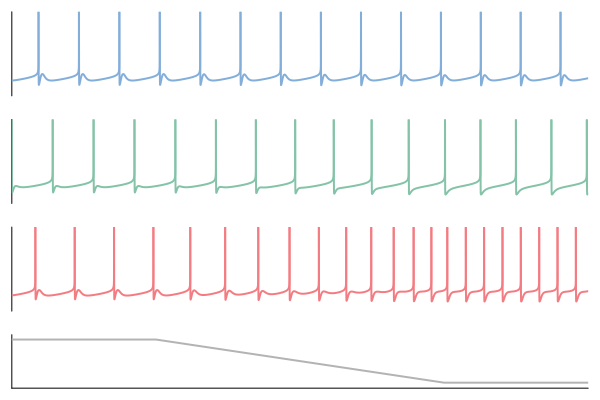

In [12]:
const Tfinal = 10000
const tspan  = (0.0, Tfinal)
include("FYON_2022_DA_models.jl") # Loading of STG model

is = [33, 111, 83]
i = is[1]
(gNa_HS, gKd_HS, gCaL_HS, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS) = g_all_MC[i, :]
gCaL_fun1(t) = gCaL_HS*(t<=8000) - 0.9*gCaL_HS*(t-4000)/4000*((t>=4000)&&(t<=8000))+0.1*gCaL_HS*(t>8000)
p = [0., gNa_HS, gKd_HS, gCaL_fun1, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS, C]

# Initial conditions
V0  = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_CR2, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
idx = findall(sol.t .> 2000)
V_t_HS = sol[1, idx]
t_HS = sol.t[idx]
p1 = plot(t_HS, V_t_HS, color=myBlue, yguidefontsize=18, xguidefontsize=18, 
            legendfontsize=12, legend=false, 
           yticks=false, tickfontsize=15, grid=false, linewidth=2,
           xaxis=false, xticks=false, size=(600, 115))
ylims!((-100, 50))
xlims!((2000, 10000))

i = is[2]
(gNa_HS, gKd_HS, gCaL_HS, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS) = g_all_MC[i, :]
gCaL_fun2(t) = gCaL_HS*(t<=8000) - 0.9*gCaL_HS*(t-4000)/4000*((t>=4000)&&(t<=8000))+0.1*gCaL_HS*(t>8000)
p = [0., gNa_HS, gKd_HS, gCaL_fun2, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS, C]

# Simulation
prob = ODEProblem(DA_ODE_CR2, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
idx = findall(sol.t .> 2000)
V_t_HS = sol[1, idx]
t_HS = sol.t[idx]
p2 = plot(t_HS, V_t_HS, color=myGreen, yguidefontsize=18, xguidefontsize=18, 
        legendfontsize=12, legend=false, 
           yticks=false, tickfontsize=15, grid=false, linewidth=2,
           xaxis=false, xticks=false, size=(600, 115))
ylims!((-100, 50))
xlims!((2000, 10000))

i = is[3]
(gNa_HS, gKd_HS, gCaL_HS, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS) = g_all_MC[i, :]
gCaL_fun3(t) = gCaL_HS*(t<=8000) - 0.9*gCaL_HS*(t-4000)/4000*((t>=4000)&&(t<=8000))+0.1*gCaL_HS*(t>8000)
gERG_fun(t) = gERG_HS*(t<=8000) - 0.5*gERG_HS*(t-4000)/4000*((t>=4000)&&(t<=8000))+0.5*gERG_HS*(t>8000)
p = [0., gNa_HS, gKd_HS, gCaL_fun3, gCaN_HS, gERG_fun, gNMDA_HS, gleak_HS, C]

# Initial conditions
V0  = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_CR3, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
idx = findall(sol.t .> 2000)
V_t_HS = sol[1, idx]
t_HS = sol.t[idx]
p3 = plot(t_HS, V_t_HS, color=mySalmon, yguidefontsize=18, xguidefontsize=18, legendfontsize=12, 
          legend=false, 
           yticks=false, tickfontsize=15, grid=false, linewidth=2,
           xticks=false, xaxis=false, size=(600, 115))
ylims!((-100, 50))
xlims!((2000, 10000))



p4 = plot(t_HS, gCaL_fun3.(t_HS), yguidefontsize=18, xguidefontsize=18, legendfontsize=12, legend=false, 
           yticks=false, tickfontsize=15, grid=false, xticks=false, size=(600, 55), 
        linewidth=2, color=:gray70)
ylims!((minimum(gCaL_fun3.(t_HS))-0.01, maximum(gCaL_fun3.(t_HS))*1.1))
xlims!((2000, 10000))

l = @layout [
    a{1.0*w,0.275*h}
    b{1.0*w,0.275*h}
    c{1.0*w,0.275*h}
    d{1.0*w,0.175*h}
]

CC = plot(p1, p2, p3, p4, layout=l, size = (600, 400))
display(CC)

# CC = savefig("cartoon_CR_DA.pdf")

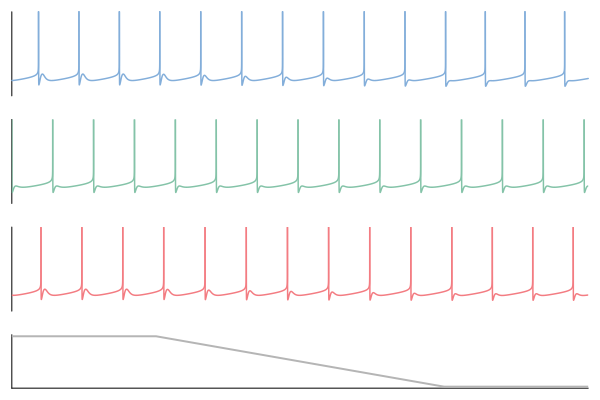

In [45]:
const Tfinal = 10000
const tspan  = (0.0, Tfinal)
include("FYON_2022_DA_models.jl") # Loading of STG model

is = [33, 111, 58]
i = is[1]
(gNa_HS, gKd_HS, gCaL_HS, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS) = g_all_MC[i, :]
gCaN_fun1(t) = gCaN_HS*(t<=8000) - 0.9*gCaN_HS*(t-4000)/4000*((t>=4000)&&(t<=8000))+0.1*gCaN_HS*(t>8000)
p = [0., gNa_HS, gKd_HS, gCaL_HS, gCaN_fun1, gERG_HS, gNMDA_HS, gleak_HS, C]

# Initial conditions
V0  = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_CR, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
idx = findall(sol.t .> 2000)
V_t_HS = sol[1, idx]
t_HS = sol.t[idx]
p1 = plot(t_HS, V_t_HS, color=myBlue, yguidefontsize=18, xguidefontsize=18, 
            legendfontsize=12, legend=false, 
           yticks=false, tickfontsize=15, grid=false, linewidth=1.5,
           xaxis=false, xticks=false, size=(600, 115))
ylims!((-100, 50))
xlims!((2000, 10000))

i = is[2]
(gNa_HS, gKd_HS, gCaL_HS, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS) = g_all_MC[i, :]
gCaN_fun2(t) = gCaN_HS*(t<=8000) - 0.9*gCaN_HS*(t-4000)/4000*((t>=4000)&&(t<=8000))+0.1*gCaN_HS*(t>8000)
p = [0., gNa_HS, gKd_HS, gCaL_HS, gCaN_fun2, gERG_HS, gNMDA_HS, gleak_HS, C]

# Simulation
prob = ODEProblem(DA_ODE_CR, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
idx = findall(sol.t .> 2000)
V_t_HS = sol[1, idx]
t_HS = sol.t[idx]
p2 = plot(t_HS, V_t_HS, color=myGreen, yguidefontsize=18, xguidefontsize=18, 
        legendfontsize=12, legend=false, 
           yticks=false, tickfontsize=15, grid=false, linewidth=1.5,
           xaxis=false, xticks=false, size=(600, 115))
ylims!((-100, 50))
xlims!((2000, 10000))

i = is[3]
(gNa_HS, gKd_HS, gCaL_HS, gCaN_HS, gERG_HS, gNMDA_HS, gleak_HS) = g_all_MC[i, :]
gCaN_fun3(t) = gCaN_HS*(t<=8000) - 0.9*gCaN_HS*(t-4000)/4000*((t>=4000)&&(t<=8000))+0.1*gCaN_HS*(t>8000)
p = [0., gNa_HS, gKd_HS, gCaL_HS, gCaN_fun3, gERG_HS, gNMDA_HS, gleak_HS, C]

# Initial conditions
V0  = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_CR, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
idx = findall(sol.t .> 2000)
V_t_HS = sol[1, idx]
t_HS = sol.t[idx]
p3 = plot(t_HS, V_t_HS, color=mySalmon, yguidefontsize=18, xguidefontsize=18, legendfontsize=12, 
          legend=false, 
           yticks=false, tickfontsize=15, grid=false, linewidth=1.5,
           xticks=false, xaxis=false, size=(600, 115))
ylims!((-100, 50))
xlims!((2000, 10000))



p4 = plot(t_HS, gCaN_fun3.(t_HS), yguidefontsize=18, xguidefontsize=18, legendfontsize=12, legend=false, 
           yticks=false, tickfontsize=15, grid=false, xticks=false, size=(600, 55), 
        linewidth=2, color=:gray71)
#ylims!((minimum(gCaN_fun3.(t_HS))-0.01, maximum(gCaN_fun3.(t_HS))*1.1))
xlims!((2000, 10000))

l = @layout [
    a{1.0*w,0.275*h}
    b{1.0*w,0.275*h}
    c{1.0*w,0.275*h}
    d{1.0*w,0.175*h}
]

CC = plot(p1, p2, p3, p4, layout=l, size = (600, 400))
display(CC)

# CC = savefig("cartoon_HS_DA.pdf")

# **New figure 2**

In [17]:
# Means on spiking point cloud
mean_MC = zeros(1, nb_channels)
mean!(mean_MC, g_all_MC_wout_NMDA)

# Defining scaling factors and limits for the plots
s1 = 2
s2 = 2

# Normalizing data before applying PCA
g_all_MC_norm = deepcopy(g_all_MC_wout_NMDA)
for i = 1 : nb_channels
    g_all_MC_norm[:, i] = g_all_MC_wout_NMDA[:, i] / std(g_all_MC_wout_NMDA[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC = cov(g_all_MC_norm)
eig_MC = eigen(cov_matrix_MC, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_plot = deepcopy(eig_MC)
for i = 1 : nb_channels
    eig_MC_plot.vectors[i, :] = eig_MC_plot.vectors[i, :] *
                                        std(g_all_MC_wout_NMDA[:, i])
end

In [18]:
Random.seed!(2022)
N = 2000
eig_val_MC_shuffle = zeros(nb_channels, N)
eig_val_decreasing_shuffle = zeros(nb_channels, N)
for j = 1 : N
    g_all_MC_shuffle = zero(g_all_MC_wout_NMDA)
    for i = 1 : nb_channels
        g_all_MC_shuffle[:, i] = shuffle(g_all_MC_wout_NMDA[:, i])
    end

    # Normalizing data before applying PCA
    g_all_MC_shuffle_norm = deepcopy(g_all_MC_shuffle)
    for i = 1 : nb_channels
        g_all_MC_shuffle_norm[:, i] = g_all_MC_shuffle[:, i] / std(g_all_MC_shuffle[:, i])
    end

    # PCA on spiking point cloud
    cov_matrix_MC_shuffle = cov(g_all_MC_shuffle_norm)
    eig_MC_shuffle = eigen(cov_matrix_MC_shuffle, sortby = x -> abs(x))
    eig_val_MC_shuffle[:, j] = eig_MC_shuffle.values
    
    total_var_shuffle = sum(eig_val_MC_shuffle[:, j])
    eig_val_decreasing_shuffle[:, j] = reverse(eig_val_MC_shuffle[:, j]) ./ total_var_shuffle
end

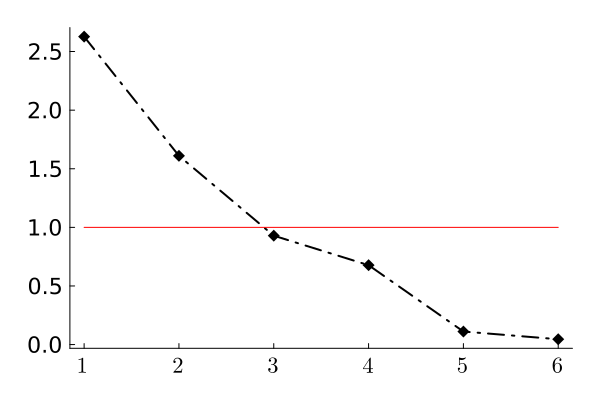

In [14]:
plot(reverse(eig_MC.values), label = "", grid=false, guidefontsize=18, markershape=:diamond, 
            linestyle=:dashdot, legendfontsize=12, margin=5Plots.mm, 
            xticks=([1, 2, 3, 4, 5, 6, 7, 8], [L"1", L"2", L"3", L"4", L"5", L"6", L"7", L"8"]), 
            color=:black, markersize=6, linewidth=2, tickfontsize=15,
            size=(600, 400))
plot!([1, 6], [1, 1], color=:red, label="")

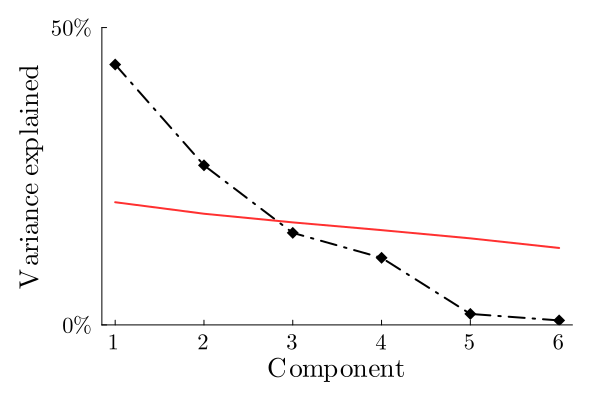

In [15]:
total_var = sum(eig_MC.values)
eig_val_decreasing = reverse(eig_MC.values) ./ total_var

p1a  = plot(eig_val_decreasing, label="", grid=false, guidefontsize=18, markershape=:diamond, 
            linestyle=:dashdot, legendfontsize=12, margin=5Plots.mm, 
            xticks=([1, 2, 3, 4, 5, 6, 7, 8], [L"1", L"2", L"3", L"4", L"5", L"6", L"7", L"8"]), 
            color=:black, markersize=6, linewidth=2, tickfontsize=15,
            yticks=([0, 0.5], [L"0\%", L"50\%"]), size=(600, 400))

plot!(mean(eig_val_decreasing_shuffle, dims=2), label="", grid=false,
      linestyle=:solid, color=:firebrick1, markersize=6, linewidth=2)
ylims!((0., 0.5))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Variance}\,\,\mathrm{explained}")
display(p1a)
# savefig(p1a, "./figures/DA_MC_scree_shuffle.pdf")

In [11]:
important_PCA = 0
eig_val_decreasing = reverse(eig_MC.values)
eig_val_decreasing_shuffle = reverse(mean(eig_val_MC_shuffle, dims=2))
while(eig_val_decreasing[important_PCA+1] > eig_val_decreasing_shuffle[important_PCA+1])
    important_PCA = important_PCA + 1
end
display(important_PCA)

2

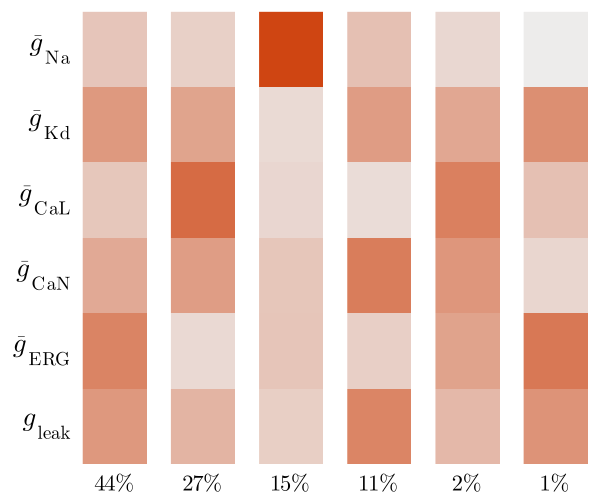

In [12]:
CC = heatmap_dir(eig_MC, nb_channels)
display(CC)
# savefig(CC, "./figures/DA_MC_eig_vectors.pdf")

# **New figure 3**

In [19]:
PC1_abs = abs.(eig_MC.vectors[:, nb_channels]) ./ 
        norm(eig_MC.vectors[:, nb_channels])
best_four = sortperm(PC1_abs, rev=true)[1:4];

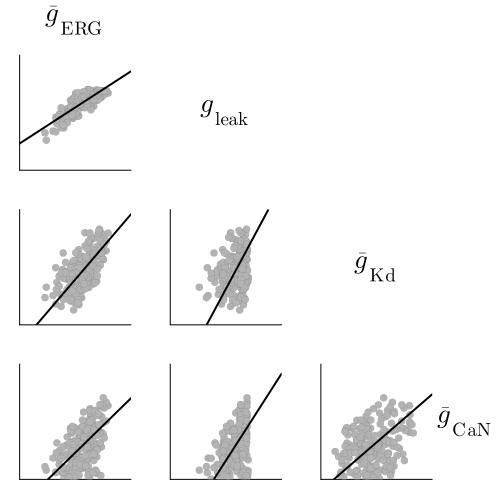

In [14]:
dir_val = eig(eig_MC_plot.values[end],  eig_MC_plot.vectors[best_four, :])
CC = scatter_matrix3x3(g_all_MC_wout_NMDA[:, best_four], maxs[best_four], :gray70, :none, names[best_four], 
                       flag=1, dir_val=dir_val, mean_vec=mean_MC[best_four], s1=1000)
display(CC)
# savefig(CC, "./figures/DA_MC_matrix3x3_PC1.pdf")

In [15]:
function gram_schmidt(A)
    m, n = size(A)
    Q = similar(A)
    R = zeros(n, n)
    for j = 1 : n
        v = A[:, j]
        for i = 1 : j-1
            R[i, j] = dot(Q[:, i], A[:, j])
            v -= R[i, j] * Q[:, i]
        end
        R[j, j] = norm(v)
        Q[:, j] = v / R[j, j]
    end
    return Q, R
end;

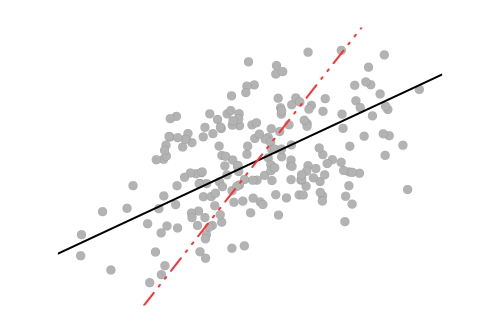

In [16]:
PC1 = -eig_MC.vectors[:, nb_channels]
homo_scaling = deepcopy(vec(mean_MC))
for i = 1 : nb_channels
    homo_scaling[i] = homo_scaling[i] / std(g_all_MC_wout_NMDA[:, i])
end
base = zeros(nb_channels, 2)
base[:, 1] = PC1
base[:, 2] = homo_scaling ./ norm(homo_scaling)
rotation_angle = -25
R = [cosd(rotation_angle) -sind(rotation_angle); sind(rotation_angle) cosd(rotation_angle)]

Q, _ = gram_schmidt(base)
Q = Q *R

g_all_MC_Qbase = g_all_MC_norm * Q

p = scatter(g_all_MC_Qbase[:, 1], g_all_MC_Qbase[:, 2], label="", color=:gray70, grid=false,
        yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, axis=false,
        markerstrokewidth=0., markersize=5, ticks=false, aspect_ratio=:equal, size=(500, 333))

mean_g_all_MC_Qbase = mean(g_all_MC_Qbase, dims=1)
points = zeros(2, nb_channels)
s = 50
points[1, :] = -PC1*s
points[2, :] = PC1*s
points = points * Q
plot!(points[:, 1] .+ mean_g_all_MC_Qbase[1], points[:, 2] .+ mean_g_all_MC_Qbase[2],
      arrow=false, color=:black, linewidth=2, label="", linestyle=:solid)

points = zeros(2, nb_channels)
points[1, :] = -homo_scaling*s
points[2, :] = homo_scaling*s
points = points * Q
plot!(points[:, 1] .+ mean_g_all_MC_Qbase[1], points[:, 2] .+ mean_g_all_MC_Qbase[2],
      arrow=false, color=:firebrick1, linewidth=2, label="", linestyle=:dashdotdot)

xlims!((minimum(g_all_MC_Qbase[:, 1])-0.5, maximum(g_all_MC_Qbase[:, 1])+0.5))
ylims!((minimum(g_all_MC_Qbase[:, 2])-0.5, maximum(g_all_MC_Qbase[:, 2])+0.5))
# xlabel!(L"\mathrm{PC}1")
# ylabel!(L"\mathrm{Homogeneous}\,\,\mathrm{scaling}")
display(p)
# savefig(p, "./figures/DA_MC_PC1_homo.pdf")

In [17]:
function angle_between_vectors(u, v)
    dot_prod = dot(u, v)
    norm_u = norm(u)
    norm_v = norm(v)
    angle = acosd(dot_prod / (norm_u * norm_v))
    return angle
end

display(angle_between_vectors(PC1, homo_scaling))
display(cosd(angle_between_vectors(PC1, homo_scaling)))

26.93935589135274

0.8914865464216547

# **New figure 4**

In [20]:
g_all_spiking = readdlm("./data/g_all_spiking.dat")
g_all_spiking_DIC = readdlm("./data/g_all_spiking_DIC.dat")
g_all_spiking_leak = readdlm("./data/g_all_spiking_leak.dat")

g_all_triplets = readdlm("./data/g_all_triplets.dat")
g_all_triplets_DIC = readdlm("./data/g_all_triplets_DIC.dat")
g_all_triplets_leak = readdlm("./data/g_all_triplets_leak.dat")

g_all_bursting = readdlm("./data/g_all_bursting.dat")
g_all_bursting_DIC = readdlm("./data/g_all_bursting_DIC.dat")
g_all_bursting_leak = readdlm("./data/g_all_bursting_leak.dat")

const ncells = 500;

In [19]:
# Initializing some variables
g_all_spiking_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_spiking_wout_NMDA[:, j] = deepcopy(g_all_spiking[:, i])
    j = j + 1
end

# Means on spiking point cloud
mean_spiking = zeros(1, nb_channels)
mean!(mean_spiking, g_all_spiking_wout_NMDA)

# Defining scaling factors and limits for the plots
s1 = 1.8
s2 = 1.3
Na_max = 60
Kd_max = 20
CaL_max = 0.1
CaN_max = 0.3
ERG_max = 0.25
leak_max = 0.02

# Normalizing data before applying PCA
g_all_spiking_norm = deepcopy(g_all_spiking_wout_NMDA)
for i = 1 : nb_channels
    g_all_spiking_norm[:, i] = g_all_spiking_wout_NMDA[:, i] / std(g_all_spiking_wout_NMDA[:, i])
end

# PCA on spiking point cloud
cov_matrix_spiking = cov(g_all_spiking_norm)
eig_spiking = eigen(cov_matrix_spiking, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_spiking_plot = deepcopy(eig_spiking)
for i = 1 : nb_channels
    eig_spiking_plot.vectors[i, :] = eig_spiking_plot.vectors[i, :] *
                                        std(g_all_spiking_wout_NMDA[:, i])
end

In [20]:
# Initializing some variables
g_all_spiking_leak_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_spiking_leak_wout_NMDA[:, j] = deepcopy(g_all_spiking_leak[:, i])
    j = j + 1
end

# Initializing some variables
g_all_spiking_DIC_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_spiking_DIC_wout_NMDA[:, j] = deepcopy(g_all_spiking_DIC[:, i])
    j = j + 1
end

In [21]:
Random.seed!(2022)
N = 2000
eig_val_spiking_shuffle = zeros(nb_channels, N)
eig_val_decreasing_shuffle = zeros(nb_channels, N)
for j = 1 : N
    g_all_spiking_shuffle = zero(g_all_spiking_wout_NMDA)
    for i = 1 : nb_channels
        g_all_spiking_shuffle[:, i] = shuffle(g_all_spiking_wout_NMDA[:, i])
    end

    # Normalizing data before applying PCA
    g_all_spiking_shuffle_norm = deepcopy(g_all_spiking_shuffle)
    for i = 1 : nb_channels
        g_all_spiking_shuffle_norm[:, i] = g_all_spiking_shuffle[:, i] / std(g_all_spiking_shuffle[:, i])
    end

    # PCA on spiking point cloud
    cov_matrix_spiking_shuffle = cov(g_all_spiking_shuffle_norm)
    eig_spiking_shuffle = eigen(cov_matrix_spiking_shuffle, sortby = x -> abs(x))
    eig_val_spiking_shuffle[:, j] = eig_spiking_shuffle.values
    
    total_var_shuffle = sum(eig_val_spiking_shuffle[:, j])
    eig_val_decreasing_shuffle[:, j] = reverse(eig_val_spiking_shuffle[:, j]) ./ total_var_shuffle
end

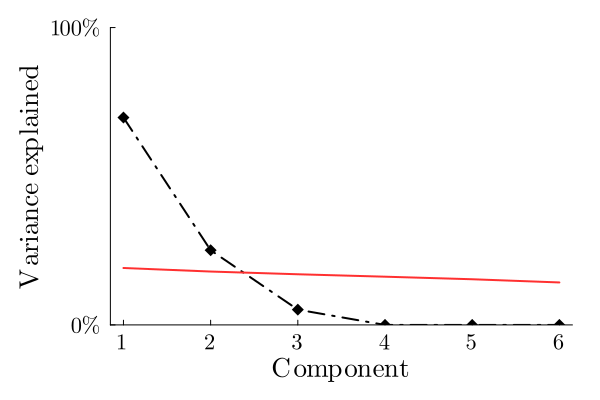

In [22]:
total_var = sum(eig_spiking.values)
eig_val_decreasing = reverse(eig_spiking.values) ./ total_var

p1a  = plot(eig_val_decreasing, label="", grid=false, guidefontsize=18, markershape=:diamond, 
            linestyle=:dashdot, legendfontsize=12, margin=5Plots.mm, 
            xticks=([1, 2, 3, 4, 5, 6, 7, 8], [L"1", L"2", L"3", L"4", L"5", L"6", L"7", L"8"]), 
            color=:black, markersize=6, linewidth=2, tickfontsize=15,
            yticks=([0, 1.], [L"0\%", L"100\%"]), size=(600, 400))

plot!(mean(eig_val_decreasing_shuffle, dims=2), label="", grid=false,
      linestyle=:solid, color=:firebrick1, markersize=6, linewidth=2)
ylims!((0., 1.))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Variance}\,\,\mathrm{explained}")
display(p1a)
# savefig(p1a, "./figures/DA_spiking_scree_shuffle.pdf")

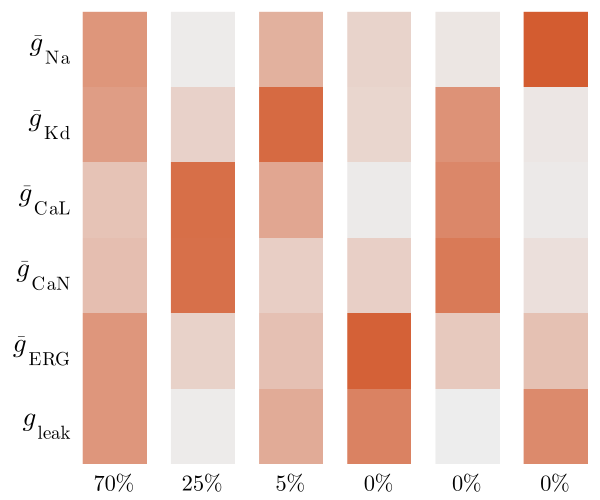

In [23]:
CC = heatmap_dir(eig_spiking, nb_channels)
display(CC)
# savefig(CC, "./figures/DA_spiking_eig_vectors.pdf")

In [24]:
PC2_abs = abs.(eig_spiking.vectors[:, nb_channels-1]) ./ 
        norm(eig_spiking.vectors[:, nb_channels-1])
best_four = sortperm(PC2_abs, rev=true)[1:4];

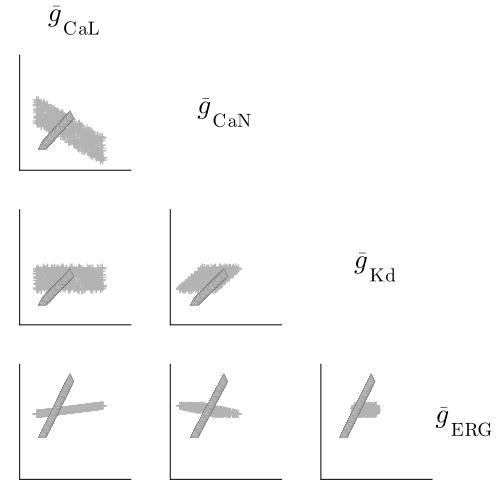

In [25]:
CC = scatter_matrix3x3(g_all_spiking_DIC_wout_NMDA[:, best_four], maxs[best_four], :gray70, :cross, 
                       names[best_four], flag=3, flag2=1, 
                       g_all2=g_all_spiking_leak_wout_NMDA[:, best_four], m_shape2=:utriangle)
display(CC)
# savefig(CC, "./figures/DA_spiking_matrix3x3_separated.pdf")

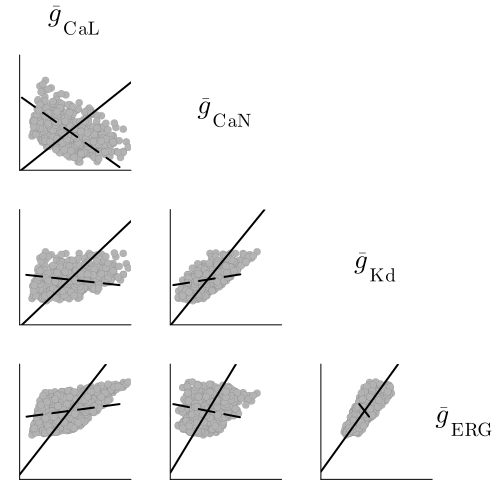

In [26]:
dir_val = eig(eig_spiking_plot.values[end],  eig_spiking_plot.vectors[best_four, :])
CC = scatter_matrix3x3(g_all_spiking_wout_NMDA[:, best_four], maxs[best_four], :gray70, :none, 
                       names[best_four], flag=2, dir_val=dir_val, 
                       mean_vec=mean_spiking[best_four], s1=10, s2=0.8)
display(CC)
# savefig(CC, "./figures/DA_spiking_matrix3x3_PC12.pdf")

# **New figure 7**

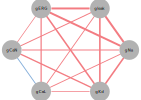

In [27]:
nb_edges = Int(nb_channels * (nb_channels-1) / 2)
r_values = zeros(nb_edges)
i1 = 1
i2 = 2
for i = 1 : nb_edges
    r_values[i] = cor(g_all_spiking_wout_NMDA[:, i1], g_all_spiking_wout_NMDA[:, i2])
    if abs(r_values[i]) < 1/nb_channels
        r_values[i] = 0.0
    end
    if i2 == i1 + 1
        i1 = 1
        i2 = i2 + 1
    else
        i1 = i1 + 1
    end
end

mysalmon = colorant"rgb(243, 124, 130)"
myblue = colorant"rgb(131, 174, 218)"
coloredges = [mysalmon for i = 1 : nb_edges]
for i = 1 : nb_edges
    if r_values[i] < 0
        coloredges[i] = myblue
    end
end
A = ones(nb_channels, nb_channels)
for i = 1 : nb_channels
    A[i, i] = 0
end
AA = convert(Array{Int64}, A)
GG = SimpleWeightedGraph(AA)
nodecolors=[RGB(0.7,0.7,0.7) for i=1:nb_channels]
nodelabel = ["gNa", "gKd", "gCaL", "gCaN", "gERG", "gleak"]

gdraw = gplot(GG, layout=circular_layout, nodefillc=nodecolors, nodelabel=nodelabel, NODESIZE=0.175,
              edgelinewidth=abs.(r_values), EDGELINEWIDTH=2, edgestrokec=coloredges)
display(gdraw)
# draw(SVG("./figures/DA_graph_corr_spiking.svg", 16cm, 10cm), gdraw);

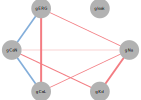

In [28]:
nb_edges = Int(nb_channels * (nb_channels-1) / 2)
r_values = zeros(nb_edges)
i1 = 1
i2 = 2
for i = 1 : nb_edges
    r_values[i] = cor(g_all_spiking_DIC_wout_NMDA[:, i1], g_all_spiking_DIC_wout_NMDA[:, i2])
    if abs(r_values[i]) < 1/nb_channels
        r_values[i] = 0.0
    end
    if i2 == i1 + 1
        i1 = 1
        i2 = i2 + 1
    else
        i1 = i1 + 1
    end
end

mysalmon = colorant"rgb(243, 124, 130)"
myblue = colorant"rgb(131, 174, 218)"
coloredges = [mysalmon for i = 1 : nb_edges]
for i = 1 : nb_edges
    if r_values[i] < 0
        coloredges[i] = myblue
    end
end
A = ones(nb_channels, nb_channels)
for i = 1 : nb_channels
    A[i, i] = 0
end
AA = convert(Array{Int64}, A)
GG = SimpleWeightedGraph(AA)
nodecolors=[RGB(0.7,0.7,0.7) for i=1:nb_channels]
nodelabel = ["gNa", "gKd", "gCaL", "gCaN", "gERG", "gleak"]

gdraw = gplot(GG, layout=circular_layout, nodefillc=nodecolors, nodelabel=nodelabel, NODESIZE=0.175,
              edgelinewidth=abs.(r_values), EDGELINEWIDTH=2, edgestrokec=coloredges)
display(gdraw)
# draw(SVG("./figures/DA_graph_corr_spiking_DIC.svg", 16cm, 10cm), gdraw);

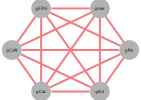

In [29]:
nb_edges = Int(nb_channels * (nb_channels-1) / 2)
r_values = zeros(nb_edges)
i1 = 1
i2 = 2
for i = 1 : nb_edges
    r_values[i] = cor(g_all_spiking_leak_wout_NMDA[:, i1], g_all_spiking_leak_wout_NMDA[:, i2])
    if abs(r_values[i]) < 1/nb_channels
        r_values[i] = 0.0
    end
    if i2 == i1 + 1
        i1 = 1
        i2 = i2 + 1
    else
        i1 = i1 + 1
    end
end

mysalmon = colorant"rgb(243, 124, 130)"
myblue = colorant"rgb(131, 174, 218)"
coloredges = [mysalmon for i = 1 : nb_edges]
for i = 1 : nb_edges
    if r_values[i] < 0
        coloredges[i] = myblue
    end
end
A = ones(nb_channels, nb_channels)
for i = 1 : nb_channels
    A[i, i] = 0
end
AA = convert(Array{Int64}, A)
GG = SimpleWeightedGraph(AA)
nodecolors=[RGB(0.7,0.7,0.7) for i=1:nb_channels]
nodelabel = ["gNa", "gKd", "gCaL", "gCaN", "gERG", "gleak"]

gdraw = gplot(GG, layout=circular_layout, nodefillc=nodecolors, nodelabel=nodelabel, NODESIZE=0.175,
              edgelinewidth=abs.(r_values), EDGELINEWIDTH=2, edgestrokec=coloredges)
display(gdraw)
# draw(SVG("./figures/DA_graph_corr_spiking_leak.svg", 16cm, 10cm), gdraw);

# **New figure 5 (from an old one)**

In [30]:
# Extracting threshold voltage and weighting factors for a specific neuron
(gNa, gKd, gCaL, gCaN, gERG, gNMDA, gleak) = g_all_MC[1, :]
(ith, iosc, gf, gs, gu, gin, Istatic) = DICs(V, 0., gNa, gKd, gCaL, gCaN, gERG, gNMDA, gleak)
Vth = V[ith]
tau_f = tau_m(Vth)
tau_s = tau_n(Vth)
tau_u = 100. # Fixed because no tau for the ERG current
(wfs_m, wsu_m) = var_contribution(tau_m(Vth), tau_f, tau_s, tau_u)
(wfs_h, wsu_h) = var_contribution(tau_h(Vth), tau_f, tau_s, tau_u)
(wfs_n, wsu_n) = var_contribution(tau_n(Vth), tau_f, tau_s, tau_u)
(wfs_mCaL, wsu_mCaL) = var_contribution(tau_mCaL(Vth), tau_f, tau_s, tau_u)
(wfs_mCaN, wsu_mCaN) = var_contribution(tau_mCaN(Vth), tau_f, tau_s, tau_u)
wfs_oERG = 0.
wsu_oERG = 0.

# Modifying scaling factors
s2 = 1.5

# Computing derivatives of gs(Vth) with respect to maximal ion channel conductances
dgs_dNa = (wsu_m - wfs_m)*3*m_inf(Vth)^2*h_inf(Vth)*(Vth-VNa)*dm(Vth) + 
          (wsu_h - wfs_h)*m_inf(Vth)^3*(Vth-VNa)*dh(Vth)
dgs_dCaL = (wsu_mCaL - wfs_mCaL)*2*mCaL_inf(Vth)*(Vth-VCa)*dmCaL(Vth)
dgs_dCaN = (wsu_mCaN - wfs_mCaN)*(Vth-VCa)*dmCaN(Vth)
dgs_dKd = (wsu_n - wfs_n)*3*n_inf(Vth)^2*(Vth-VK)*dn(Vth)
dgs_dERG = (wsu_oERG - wfs_oERG)*(Vth-VK)*doERG(Vth);

In [31]:
# Computing angles
theta_CaLCaN_DIC = -atan((dgs_dCaL/CaN_max)/(dgs_dCaN/CaL_max))
theta_CaLCaN = atan((eig_MC_plot.vectors[:, nb_channels-1][4]/CaN_max)/
                    (eig_MC_plot.vectors[:, nb_channels-1][3]/CaL_max))

theta_KdCaL_DIC = -atan((dgs_dKd/CaL_max)/(dgs_dCaL/Kd_max))
theta_KdCaL = atan((eig_MC_plot.vectors[:, nb_channels-1][3]/CaL_max)/
                   (eig_MC_plot.vectors[:, nb_channels-1][2]/Kd_max))

theta_KdCaN_DIC = -atan((dgs_dKd/CaN_max)/(dgs_dCaN/Kd_max))
theta_KdCaN4 = atan((eig_MC_plot.vectors[:, nb_channels-3][4]/CaN_max)/
                    (eig_MC_plot.vectors[:, nb_channels-3][2]/Kd_max))

theta_NaCaL_DIC = -atan((dgs_dNa/CaL_max)/(dgs_dCaL/Na_max))
theta_NaCaL4 = atan((eig_MC_plot.vectors[:, nb_channels-3][3]/CaL_max)/
                    (eig_MC_plot.vectors[:, nb_channels-3][1]/Na_max));

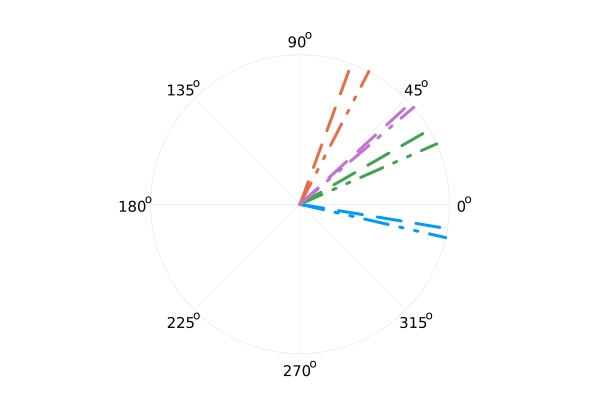

In [32]:
p2a = plot([theta_CaLCaN, theta_CaLCaN], [0, 1], proj=:polar, linewidth=3, label="", yticks=[], 
            yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
            color=1, xtickfontsize=10, linestyle=:dash)
plot!([theta_CaLCaN_DIC, theta_CaLCaN_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=1, linestyle=:dashdotdot)
plot!([theta_KdCaL, theta_KdCaL], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dash)
plot!([theta_KdCaL_DIC, theta_KdCaL_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dashdotdot)
plot!([theta_KdCaN4, theta_KdCaN4], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dash)
plot!([theta_KdCaN_DIC, theta_KdCaN_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dashdotdot)
plot!([theta_NaCaL_DIC, theta_NaCaL_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dashdotdot)
plot!([theta_NaCaL4, theta_NaCaL4], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dash)
ylims!(0, 1)
display(p2a)
# savefig(p2a, "./figures/DA_MC_polar_DIC.pdf")

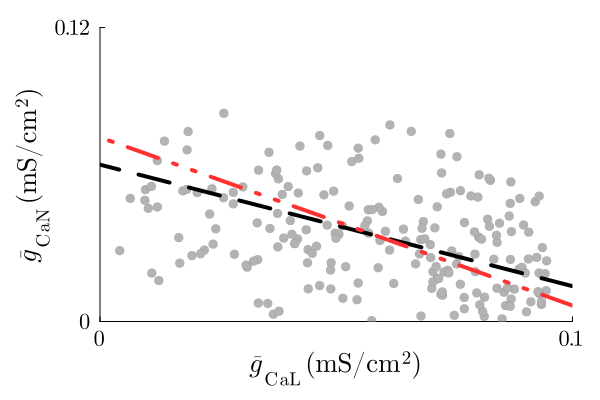

In [33]:
p2b = scatter(g_all_MC[:, 3], g_all_MC[:, 4], label="", color=:gray70, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., markersize=5, yticks=([0, 0.12], [L"0", L"0.12"]), tickfontsize=15, 
              xticks=([0, 0.1], [L"0", L"0.1"]), size=(600, 400))

s1 = 1000
s2 = 2000

plot!([mean_MC[3] - s2*2*eig_MC_plot.vectors[:, nb_channels-1][3]*eig_MC_plot.values[nb_channels-1], 
       mean_MC[3] + s2*2*eig_MC_plot.vectors[:, nb_channels-1][3]*eig_MC_plot.values[nb_channels-1]],
       [mean_MC[4] - s2*2*eig_MC_plot.vectors[:, nb_channels-1][4]*eig_MC_plot.values[nb_channels-1], 
       mean_MC[4] + s2*2*eig_MC_plot.vectors[:, nb_channels-1][4]*eig_MC_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_MC[3] - 10* dgs_dCaN, mean_MC[3] + 10*dgs_dCaN],
      [mean_MC[4] + 10*dgs_dCaL, mean_MC[4] - 10*dgs_dCaL],
      arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.1))
ylims!((0, 0.12))
display(p2b)
# savefig(p2b, "./figures/neuromod_gCaLCaN_MC_DIC.pdf")

# **New figure 6 (from an old one)**

In [34]:
g_all_spiking = readdlm("./data/g_all_spiking.dat")
g_all_spiking_DIC = readdlm("./data/g_all_spiking_DIC.dat")
g_all_spiking_leak = readdlm("./data/g_all_spiking_leak.dat")
g_all_spiking_many = readdlm("./data/g_all_spiking_many.dat")

# Definition of the number of cells in the random set
const ncells = 500;

In [35]:
# Number of ion channels in the DA model
nb_channels = 6

# Initializing some variables
g_all_spiking_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_spiking_wout_NMDA[:, j] = deepcopy(g_all_spiking[:, i])
    j = j + 1
end

# Means on spiking point cloud
mean_spiking = zeros(1, nb_channels)
mean!(mean_spiking, g_all_spiking_wout_NMDA)

# Defining scaling factors and limits for the plots
s1 = 1.8
s2 = 1.3
Na_max = 60
Kd_max = 20
CaL_max = 0.1
CaN_max = 0.3
ERG_max = 0.25
leak_max = 0.02

# Normalizing data before applying PCA
g_all_spiking_norm = deepcopy(g_all_spiking_wout_NMDA)
for i = 1 : nb_channels
    g_all_spiking_norm[:, i] = g_all_spiking_wout_NMDA[:, i] / std(g_all_spiking_wout_NMDA[:, i])
end

# PCA on spiking point cloud
cov_matrix_spiking = cov(g_all_spiking_norm)
eig_spiking = eigen(cov_matrix_spiking, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_spiking_plot = deepcopy(eig_spiking)
for i = 1 : nb_channels
    eig_spiking_plot.vectors[i, :] = eig_spiking_plot.vectors[i, :] *
                                        std(g_all_spiking_wout_NMDA[:, i])
end

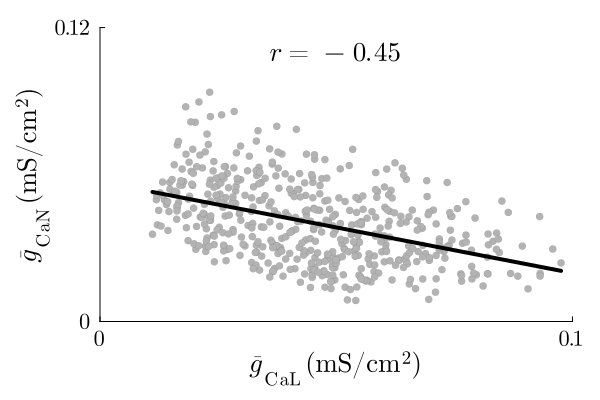

In [36]:
p4a = scatter(g_all_spiking[:, 3], g_all_spiking[:, 4], label="", color=:gray70, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., yticks=([0, 0.12], [L"0", L"0.12"]), tickfontsize=15, 
              xticks=([0, 0.1], [L"0", L"0.1"]), size=(600, 400))

s1 = 1000
s2 = 2000

# plot!([mean_spiking[3] - s1*eig_spiking_plot.vectors[:, nb_channels][3]*eig_spiking_plot.values[nb_channels], 
#        mean_spiking[3] + s1*eig_spiking_plot.vectors[:, nb_channels][3]*eig_spiking_plot.values[nb_channels]],
#        [mean_spiking[4] - s1*eig_spiking_plot.vectors[:, nb_channels][4]*eig_spiking_plot.values[nb_channels], 
#        mean_spiking[4] + s1*eig_spiking_plot.vectors[:, nb_channels][4]*eig_spiking_plot.values[nb_channels]],
#        arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

# plot!([mean_spiking[3] - s2*eig_spiking_plot.vectors[:, nb_channels-1][3]*eig_spiking_plot.values[nb_channels-1], 
#        mean_spiking[3] + s2*eig_spiking_plot.vectors[:, nb_channels-1][3]*eig_spiking_plot.values[nb_channels-1]],
#        [mean_spiking[4] - s2*eig_spiking_plot.vectors[:, nb_channels-1][4]*eig_spiking_plot.values[nb_channels-1], 
#        mean_spiking[4] + s2*eig_spiking_plot.vectors[:, nb_channels-1][4]*eig_spiking_plot.values[nb_channels-1]],
#        arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

line_34 = fit(g_all_spiking[:, 3], g_all_spiking[:, 4], 1)
s0 = minimum(g_all_spiking[:, 3])
sn = maximum(g_all_spiking[:, 3])
plot!([s0, sn], [line_34(s0), line_34(sn)], linewidth=4, label="", linecolor="black")

pearson_cor_spiking = cor(g_all_spiking[:, 3], g_all_spiking[:, 4])
str_pearson_cor_spiking = @sprintf "%.2f" pearson_cor_spiking
annotate!(0.05, 0.11, Plots.text(L"r =  %$str_pearson_cor_spiking", :black, :center, 18))

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.1))
ylims!((0, 0.12))
display(p4a)
# savefig(p4a, "./figures/PCA_DA_neuromod_gCaLCaN_spiking.pdf")

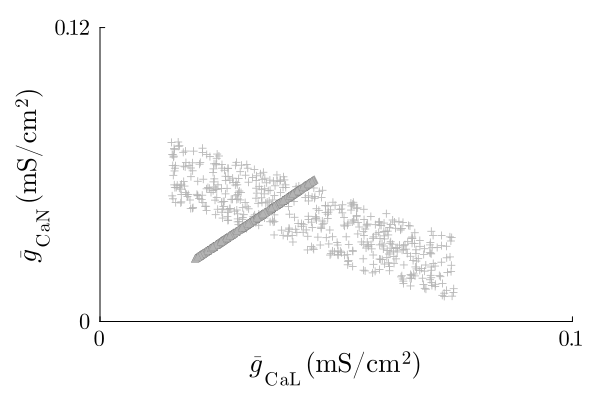

In [37]:
p4b = scatter(g_all_spiking_DIC[:, 3], g_all_spiking_DIC[:, 4], label="",
              markershape=:cross, color=:gray70, grid=false, yguidefontsize=18, 
              xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, legend=false,
              yticks=([0, 0.12], [L"0", L"0.12"]), tickfontsize=15, 
              xticks=([0, 0.1], [L"0", L"0.1"]), size=(600, 400))
scatter!(g_all_spiking_leak[:, 3], g_all_spiking_leak[:, 4], label="", 
         color=:gray70, markershape=:utriangle, markerstrokewidth=0.)

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.1))
ylims!((0, 0.12))
display(p4b)
# savefig(p4b, "./figures/neuromod_gCaLCaN_separation_spiking.pdf")

# **New figure 8 (from an old one)**

In [38]:
g_all_triplets = readdlm("./data/g_all_triplets.dat")
g_all_triplets_DIC = readdlm("./data/g_all_triplets_DIC.dat")
g_all_triplets_leak = readdlm("./data/g_all_triplets_leak.dat")

g_all_bursting = readdlm("./data/g_all_bursting.dat")
g_all_bursting_DIC = readdlm("./data/g_all_bursting_DIC.dat")
g_all_bursting_leak = readdlm("./data/g_all_bursting_leak.dat")

burstiness_triplets = readdlm("./data/burstiness_triplets.dat")
burstiness_triplets_DIC = readdlm("./data/burstiness_triplets_DIC.dat")
burstiness_triplets_leak = readdlm("./data/burstiness_triplets_leak.dat")
burstiness_bursting = readdlm("./data/burstiness_bursting.dat")
burstiness_bursting_DIC = readdlm("./data/burstiness_bursting_DIC.dat")
burstiness_bursting_leak = readdlm("./data/burstiness_bursting_leak.dat");

In [39]:
# Defining colors for the color map
mySalmon = RGB{Float64}(243. / 255., 124. / 255., 130. / 255.)
myYellow = RGB{Float64}(253. / 255., 211. / 255., 44. / 255.)
mycmap = ColorScheme([mySalmon, myYellow]);

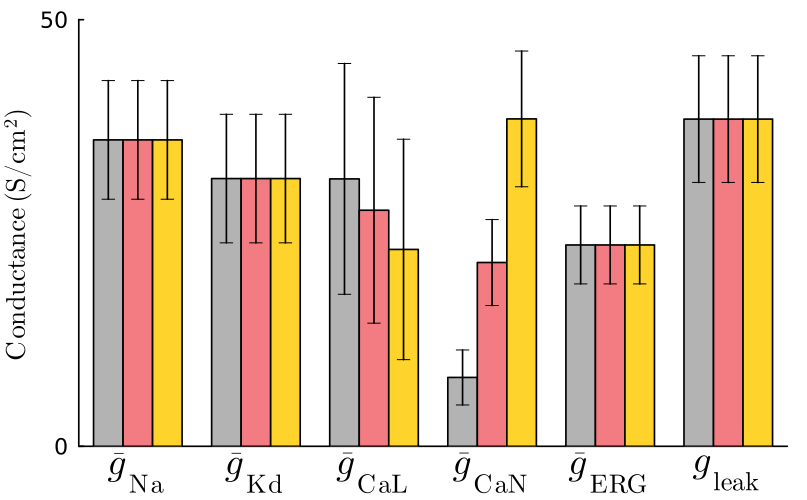

In [40]:
# Defining the number of conductances
nb_channels = 6

# Defining a matrix containing all conductances
g_all_bar = zeros(ncells, nb_channels*3)
scaling =  [1, 4, 700, 200, 200, 3000]
g_all_spiking_bar = g_all_spiking[1:end, 1:end .∉ [5]]
g_all_triplets_bar = g_all_triplets[1:end, 1:end .∉ [5]]
g_all_bursting_bar = g_all_bursting[1:end, 1:end .∉ [5]]
for i = 1 : nb_channels
    g_all_bar[:, (i-1)*3 + 1] = g_all_spiking_bar[:, i] .* scaling[i]
    g_all_bar[:, (i-1)*3 + 2] = g_all_triplets_bar[:, i] .* scaling[i]
    g_all_bar[:, (i-1)*3 + 3] = g_all_bursting_bar[:, i] .* scaling[i]
end

p4a = bar([1:4:21], mean(g_all_bar[:, 1:3:16], dims=1)', label="", grid=false, yguidefontsize=18, 
          color=:gray70, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
          margin=3Plots.mm, yticks=[0, 50],  xrotation=0, xticks=false, 
          yerror=std(g_all_bar[:, 1:3:16], dims=1)', bar_width=1, ylabel=L"\mathrm{Conductance}\,\,\mathrm{(S/cm^2)}")

bar!([2:4:22], mean(g_all_bar[:, 2:3:17], dims=1)', label="", grid=false, yguidefontsize=18, 
     color=mySalmon, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
     margin=3Plots.mm, yticks=[0, 50],  xrotation=0, xticks=false, 
     yerror=std(g_all_bar[:, 2:3:17], dims=1)', bar_width=1)

bar!([3:4:23], mean(g_all_bar[:, 3:3:18], dims=1)', label="", grid=false, yguidefontsize=18, 
     color=myYellow, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, xtickfontsize=25,
     margin=3Plots.mm, yticks=[0, 50],  xrotation=0, yerror=std(g_all_bar[:, 3:3:18], dims=1)', 
     bar_width=1, xticks=(2:4:22, [L"\bar{g}_\mathrm{Na}", L"\bar{g}_\mathrm{Kd}", L"\bar{g}_\mathrm{CaL}", 
                                   L"\bar{g}_\mathrm{CaN}", L"\bar{g}_\mathrm{ERG}", L"g_\mathrm{leak}"]))

xlims!((0., 24.))
ylims!((0, 50))

CC5 = plot(p4a, layout=(1, 1), legend=false, size=(807,500, 300))
display(CC5)
# savefig(CC5, "./figures/neuromod_gCaLCaN_gbar.pdf")

In [41]:
g_all_triplets_wout_NMDA = zeros(ncells, nb_channels)
g_all_bursting_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_triplets_wout_NMDA[:, j] = deepcopy(g_all_triplets[:, i])
    g_all_bursting_wout_NMDA[:, j] = deepcopy(g_all_bursting[:, i])
    j = j + 1
end

# Means on triplets point cloud
mean_triplets = zeros(1, nb_channels)
mean!(mean_triplets, g_all_triplets_wout_NMDA)

# Means on bursting point cloud
mean_bursting = zeros(1, nb_channels)
mean!(mean_bursting, g_all_bursting_wout_NMDA)

# Defining scaling factors for the plots
s1 = 2
s2 = 2

# Normalizing data before applying PCA
g_all_triplets_norm = deepcopy(g_all_triplets_wout_NMDA)
for i = 1 : nb_channels
    g_all_triplets_norm[:, i] = g_all_triplets_wout_NMDA[:, i] / std(g_all_triplets_wout_NMDA[:, i])
end

g_all_bursting_norm = deepcopy(g_all_bursting_wout_NMDA)
for i = 1 : nb_channels
    g_all_bursting_norm[:, i] = g_all_bursting_wout_NMDA[:, i] / std(g_all_bursting_wout_NMDA[:, i])
end

# PCA on triplets point cloud
cov_matrix_triplets = cov(g_all_triplets_norm)
eig_triplets = eigen(cov_matrix_triplets, sortby = x -> abs(x))

# PCA on bursting point cloud
cov_matrix_bursting = cov(g_all_bursting_norm)
eig_bursting = eigen(cov_matrix_bursting, sortby = x -> abs(x))

eig_triplets_plot = deepcopy(eig_triplets)
for i = 1 : nb_channels
    eig_triplets_plot.vectors[i, :] = eig_triplets_plot.vectors[i, :] *
                                        std(g_all_triplets_wout_NMDA[:, i])
end

eig_bursting_plot = deepcopy(eig_bursting)
for i = 1 : nb_channels
    eig_bursting_plot.vectors[i, :] = eig_bursting_plot.vectors[i, :] *
                                        std(g_all_bursting_wout_NMDA[:, i])
end

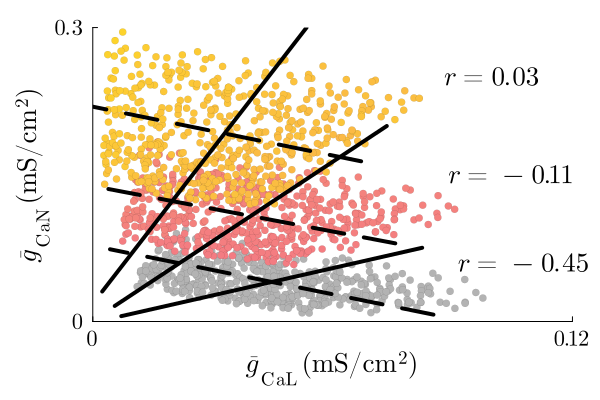

In [42]:
p5b = scatter(g_all_spiking[:, 3], g_all_spiking[:, 4], label="", grid=false, yguidefontsize=18, xguidefontsize=18, 
              margin=5Plots.mm, legend=false, color=:gray70, tickfontsize=15,
              colorbar_titlefontsize=18, markerstrokewidth=0., size=(600, 400), 
              xticks=([0, 0.12], [L"0", L"0.12"]), yticks=([0, 0.3], [L"0", L"0.3"]))
scatter!(g_all_triplets[:, 3], g_all_triplets[:, 4], label="", zcolor=burstiness_triplets, 
         c=cgrad(mycmap, rev=false), markerstrokewidth=0.)
scatter!(g_all_bursting[:, 3], g_all_bursting[:, 4], label="", zcolor=burstiness_bursting,
         c=cgrad(mycmap, rev=false), markerstrokewidth=0.)

plot!([mean_spiking[3] - s1*eig_spiking_plot.vectors[:, nb_channels][3]*eig_spiking_plot.values[nb_channels], 
       mean_spiking[3] + s1*eig_spiking_plot.vectors[:, nb_channels][3]*eig_spiking_plot.values[nb_channels]],
       [mean_spiking[4] - s1*eig_spiking_plot.vectors[:, nb_channels][4]*eig_spiking_plot.values[nb_channels], 
       mean_spiking[4] + s1*eig_spiking_plot.vectors[:, nb_channels][4]*eig_spiking_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_spiking[3] - s2*eig_spiking_plot.vectors[:, nb_channels-1][3]*eig_spiking_plot.values[nb_channels-1], 
       mean_spiking[3] + s2*eig_spiking_plot.vectors[:, nb_channels-1][3]*eig_spiking_plot.values[nb_channels-1]],
       [mean_spiking[4] - s2*eig_spiking_plot.vectors[:, nb_channels-1][4]*eig_spiking_plot.values[nb_channels-1], 
       mean_spiking[4] + s2*eig_spiking_plot.vectors[:, nb_channels-1][4]*eig_spiking_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_triplets[3] - s1*eig_triplets_plot.vectors[:, nb_channels][3]*eig_triplets_plot.values[nb_channels], 
       mean_triplets[3] + s1*eig_triplets_plot.vectors[:, nb_channels][3]*eig_triplets_plot.values[nb_channels]],
       [mean_triplets[4] - s1*eig_triplets_plot.vectors[:, nb_channels][4]*eig_triplets_plot.values[nb_channels], 
       mean_triplets[4] + s1*eig_triplets_plot.vectors[:, nb_channels][4]*eig_triplets_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_triplets[3] - s2*eig_triplets_plot.vectors[:, nb_channels-1][3]*eig_triplets_plot.values[nb_channels-1], 
       mean_triplets[3] + s2*eig_triplets_plot.vectors[:, nb_channels-1][3]*eig_triplets_plot.values[nb_channels-1]],
       [mean_triplets[4] - s2*eig_triplets_plot.vectors[:, nb_channels-1][4]*eig_triplets_plot.values[nb_channels-1], 
       mean_triplets[4] + s2*eig_triplets_plot.vectors[:, nb_channels-1][4]*eig_triplets_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_bursting[3] - s1*eig_bursting_plot.vectors[:, nb_channels][3]*eig_bursting_plot.values[nb_channels], 
       mean_bursting[3] + s1*eig_bursting_plot.vectors[:, nb_channels][3]*eig_bursting_plot.values[nb_channels]],
       [mean_bursting[4] - s1*eig_bursting_plot.vectors[:, nb_channels][4]*eig_bursting_plot.values[nb_channels], 
       mean_bursting[4] + s1*eig_bursting_plot.vectors[:, nb_channels][4]*eig_bursting_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_bursting[3] - s2*eig_bursting_plot.vectors[:, nb_channels-1][3]*eig_bursting_plot.values[nb_channels-1], 
       mean_bursting[3] + s2*eig_bursting_plot.vectors[:, nb_channels-1][3]*eig_bursting_plot.values[nb_channels-1]],
       [mean_bursting[4] - s2*eig_bursting_plot.vectors[:, nb_channels-1][4]*eig_bursting_plot.values[nb_channels-1], 
       mean_bursting[4] + s2*eig_bursting_plot.vectors[:, nb_channels-1][4]*eig_bursting_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

pearson_cor_spiking = cor(g_all_spiking[:, 3], g_all_spiking[:, 4])
str_pearson_cor_spiking = @sprintf "%.2f" pearson_cor_spiking
annotate!(0.108, 0.06, Plots.text(L"r =  %$str_pearson_cor_spiking", :black, :center, 18))

pearson_cor_triplets = cor(g_all_triplets[:, 3], g_all_triplets[:, 4])
str_pearson_cor_triplets = @sprintf "%.2f" pearson_cor_triplets
annotate!(0.105, 0.15, Plots.text(L"r =  %$str_pearson_cor_triplets", :black, :center, 18))

pearson_cor_bursting = cor(g_all_bursting[:, 3], g_all_bursting[:, 4])
str_pearson_cor_bursting = @sprintf "%.2f" pearson_cor_bursting
annotate!(0.1, 0.25, Plots.text(L"r =  %$str_pearson_cor_bursting", :black, :center, 18))

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.12))
ylims!((0, 0.3))
display(p5b)
# savefig(p5b, "./figures/PCA_DA_neuromod_gCaLCaN_burstiness.pdf")

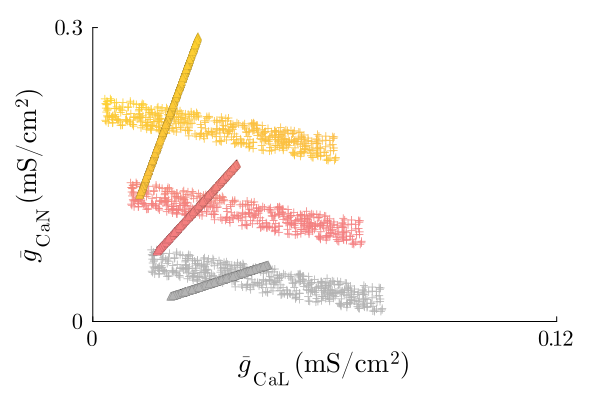

In [43]:
p5c = scatter(g_all_spiking_DIC[:, 3], g_all_spiking_DIC[:, 4], label="", legend=false,
              markershape=:cross, color=:gray70, grid=false, yguidefontsize=18, 
              xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              colorbar_title="burstiness", tickfontsize=15,
              colorbar_titlefontsize=18, size=(600, 400), 
              xticks=([0, 0.12], [L"0", L"0.12"]), yticks=([0, 0.3], [L"0", L"0.3"]))
scatter!(g_all_spiking_leak[:, 3], g_all_spiking_leak[:, 4], label="", 
         color=:gray70, markershape=:utriangle, markerstrokewidth=0.)
scatter!(g_all_triplets_DIC[:, 3], g_all_triplets_DIC[:, 4], label="", markershape=:cross,
         zcolor=burstiness_triplets_DIC, c=cgrad(mycmap, rev=false))
scatter!(g_all_triplets_leak[:, 3], g_all_triplets_leak[:, 4], label="", markerstrokewidth=0.,
         markershape=:utriangle, zcolor=burstiness_triplets_leak, c=cgrad(mycmap, rev=false))
scatter!(g_all_bursting_DIC[:, 3], g_all_bursting_DIC[:, 4], label="",
         markershape=:cross, zcolor=burstiness_bursting_DIC, c=cgrad(mycmap, rev=false))
scatter!(g_all_bursting_leak[:, 3], g_all_bursting_leak[:, 4], label="", markerstrokewidth=0.,
         markershape=:utriangle, zcolor=burstiness_bursting_leak, c=cgrad(mycmap, rev=false))

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.12))
ylims!((0, 0.3))
display(p5c)
# savefig(p5c, "./figures/neuromod_gCaLCaN_separation_burstiness.pdf")

# **New figure 9 (from an old one)**

In [44]:
burstiness = readdlm("./data/burstiness_paths.dat")
g_all_init = readdlm("./data/g_all_init_paths.dat")
gCaLs = readdlm("./data/gCaLs_paths.dat")
gCaNs = readdlm("./data/gCaNs_paths.dat");

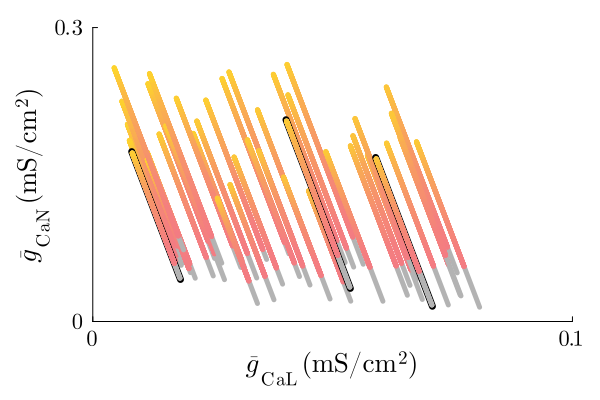

In [45]:
# Initializing some variables
n = size(gCaNs)[2]

# Picking first path randomly
Random.seed!(292)
j1 = Int(ceil(rand(1, 1)[1] * n))

# Picking second path randomly
Random.seed!(554)
j2 = Int(ceil(rand(1, 1)[1] * n))

# Picking third path randomly
Random.seed!(442)
j3 = Int(ceil(rand(1, 1)[1] * n))

# Plotting the results
p6a = plot(legend=false, tickfontsize=15, colorbar_titlefontsize=18, size=(600, 400), markerstrokewidth=0.,
           xticks=([0, 0.1], [L"0", L"0.1"]), yticks=([0, 0.3], [L"0", L"0.3"]))

# Looping over all neurons
for j = 1 : n
    # Plotting first spiking neurons
    i_thresh = minimum(findall(burstiness[:, j] .> 0))
    if i_thresh > 1
        plot!(gCaLs[1:i_thresh, j], gCaNs[1:i_thresh, j], label="", grid=false, linewidth=5, 
              yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:gray70)
    end
    
    # Then plotting bursting neurons
    plot!(gCaLs[i_thresh:end, j], gCaNs[i_thresh:end, j], label="", 
          line_z=burstiness[i_thresh:end, j], grid=false, linewidth=5, clim=(50, 500),
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, c=cgrad(mycmap, rev=false))
end

# Plotting special paths
for j in [j1, j2, j3]
    # Add a black frame to the path
    line_CaLCaN = fit(gCaLs[:, j], gCaNs[:, j], 1)
    start_x = minimum(gCaLs[:, j]) - 0.0001
    end_x = maximum(gCaLs[:, j]) + 0.0001
    plot!([start_x, end_x], [line_CaLCaN(start_x), line_CaLCaN(end_x)], 
          label="", grid=false, linewidth=7, yguidefontsize=18, 
          xguidefontsize=18, margin=5Plots.mm, color=:black)

    plot!(gCaLs[:, j], gCaNs[:, j], label="", grid=false, linewidth=5, 
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:white)
    
    # Plotting first spiking neurons
    i_thresh = minimum(findall(burstiness[:, j] .> 0))
    if i_thresh > 1
        plot!(gCaLs[1:i_thresh, j], gCaNs[1:i_thresh, j], label="", grid=false, linewidth=5, 
              yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:gray70)
    end
    
    # Then plotting bursting neurons
    plot!(gCaLs[i_thresh:end, j], gCaNs[i_thresh:end, j], label="", 
          line_z=burstiness[i_thresh:end, j], grid=false, linewidth=5, clim=(50, 500),
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, c=cgrad(mycmap, rev=false))
end

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.1))
ylims!((0, 0.3))
display(p6a)
# savefig(p6a, "./figures/neuromod_gCaLCaN_paths.pdf")

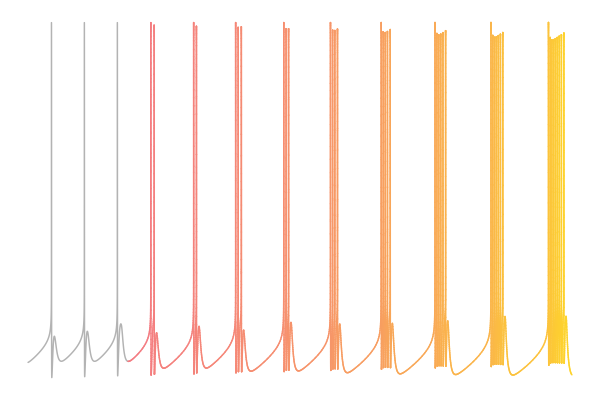

In [46]:
# Computing the regression line along the neuromodulation path
line_CaLCaN = fit(gCaLs[:, j1], gCaNs[:, j1], 1)
a0 = line_CaLCaN[0]
a1 = line_CaLCaN[1]
gCaL_min = minimum(gCaLs[:, j1])
gCaL_max = maximum(gCaLs[:, j1])

# Extracting the maximal ion channel conductances
(gNa, gKd, _, _, gERG, gNMDA, gleak) = g_all_init[j1, :]

# Parameter vector for simulations
p = [0., gNa, gKd, gCaL_min, gCaL_max, gERG, gNMDA, gleak, C, a0, a1]

# Initial conditions
V0 = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][320:end-150]
t = sol.t[320:end-150]
p6b = plot(t[1:545], V_t[1:545], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[545:end], V_t[545:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 500, length(t[545:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p6b)
# savefig(p6b, "./figures/neuromod_gCaLCaN_path_simu1.pdf")

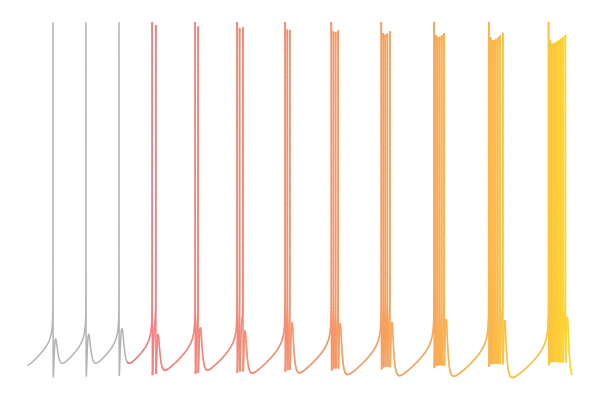

In [47]:
# Computing the regression line along the neuromodulation path
line_CaLCaN = fit(gCaLs[:, j2], gCaNs[:, j2], 1)
a0 = line_CaLCaN[0]
a1 = line_CaLCaN[1]
gCaL_min = minimum(gCaLs[:, j2])
gCaL_max = maximum(gCaLs[:, j2])

# Extracting the maximal ion channel conductances
(gNa, gKd, _, _, gERG, gNMDA, gleak) = g_all_init[j2, :]

# Parameter vector for simulations
p = [0., gNa, gKd, gCaL_min, gCaL_max, gERG, gNMDA, gleak, C, a0, a1]

# Initial conditions
V0 = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][320:end-20]
t = sol.t[320:end-20]
p6c = plot(t[1:530], V_t[1:530], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[530:end], V_t[530:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 500, length(t[530:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p6c)
# savefig(p6c, "./figures/neuromod_gCaLCaN_path_simu2.pdf")

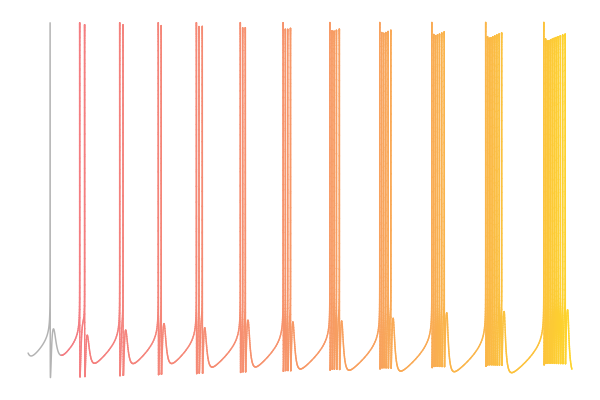

In [48]:
# Definition of simulation time (in ms)
const Tfinal = 10200
const tspan  = (0.0, Tfinal)

# Need of reloading the DA model
include("FYON_2022_DA_models.jl")

# Computing the regression line along the neuromodulation path
line_CaLCaN = fit(gCaLs[:, j3], gCaNs[:, j3], 1)
a0 = line_CaLCaN[0]
a1 = line_CaLCaN[1]
gCaL_min = minimum(gCaLs[:, j3])
gCaL_max = maximum(gCaLs[:, j3])

# Extracting the maximal ion channel conductances
(gNa, gKd, _, _, gERG, gNMDA, gleak) = g_all_init[j3, :]

# Parameter vector for simulations
p = [0., gNa, gKd, gCaL_min, gCaL_max, gERG, gNMDA, gleak, C, a0, a1]

# Initial conditions
V0 = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][320:end]
t = sol.t[320:end]
p6d = plot(t[1:185], V_t[1:185], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[185:end], V_t[185:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 500, length(t[185:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p6d)
# savefig(p6d, "./figures/neuromod_gCaLCaN_path_simu3.pdf")

# **Supplementary figures**

## **Figure S1**

In [49]:
# Definition of the number of cells in the random set
const ncells = 200

# Initializing some variables
Na_max = 60
Kd_max = 20
CaL_max = 0.1
CaN_max = 0.12
ERG_max = 0.25
leak_max = 0.02
N = 4e5
VV_maxmax = 58.5
VV_maxmin = 54
VV_minmin = -80.5
VV_minmax = -77.5
f_max = 1.95
f_min = 1.75
nb_channels = 6

g_all_MC = readdlm("./data/g_all_MC.dat")

# Initializing some variables
g_all_MC_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_MC_wout_NMDA[:, j] = deepcopy(g_all_MC[:, i])
    j = j + 1
end;

In [50]:
names = [L"\bar{g}_\mathrm{Na}", L"\bar{g}_\mathrm{Kd}", L"\bar{g}_\mathrm{CaL}", 
         L"\bar{g}_\mathrm{CaN}", L"\bar{g}_\mathrm{ERG}", L"g_\mathrm{leak}"]
maxs = [Na_max, Kd_max, CaL_max, CaN_max, ERG_max, leak_max];

5×5 Matrix{Float64}:
 0.209623  NaN         NaN          NaN         NaN
 0.206938    0.672703  NaN          NaN         NaN
 0.173075    0.311166   -0.328074   NaN         NaN
 0.147586    0.610253    0.211232     0.51359   NaN
 0.134128    0.21078    -0.0324049    0.420039    0.836091

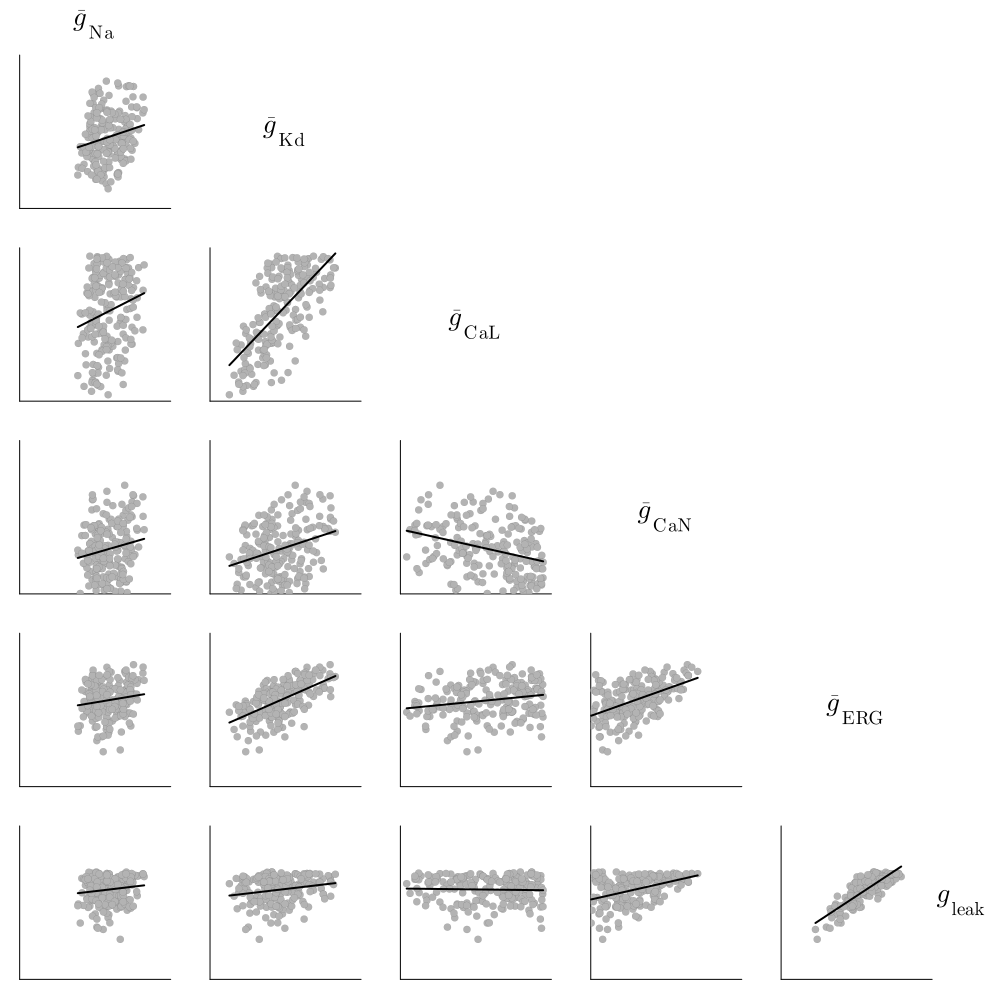

In [90]:
CC = scatter_matrix(g_all_MC_wout_NMDA, maxs, :gray70, :none, names, flag=0)
display(CC)
# savefig(CC, "./figures/DA_MC_matrix_corr.pdf")

## **Figure S2**

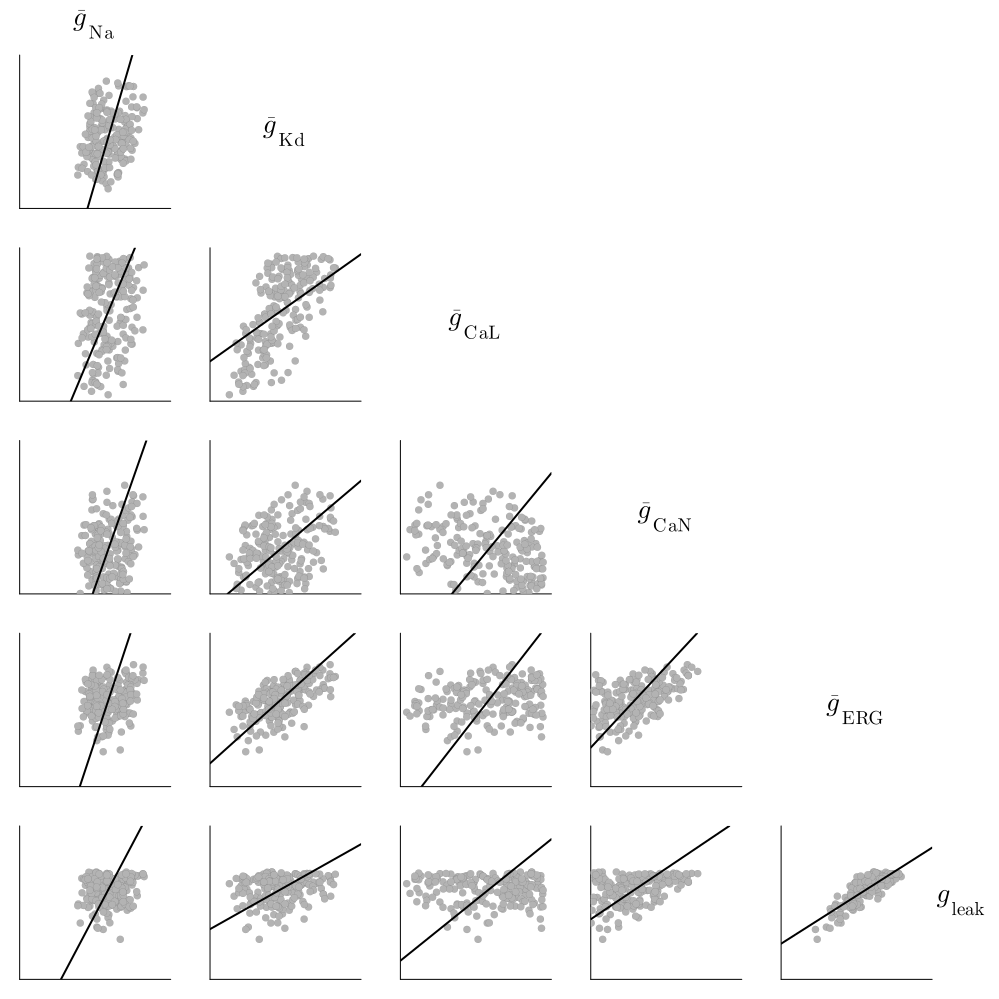

In [91]:
dir_val = eig(eig_MC_plot.values[end],  eig_MC_plot.vectors)
CC = scatter_matrix(g_all_MC_wout_NMDA, maxs, :gray70, :none, names, flag=1, dir_val=dir_val, 
                       mean_vec=mean_MC, s1=1000)
display(CC)
# savefig(CC, "./figures/DA_MC_matrix_PC1.pdf")

## **Figure S3**

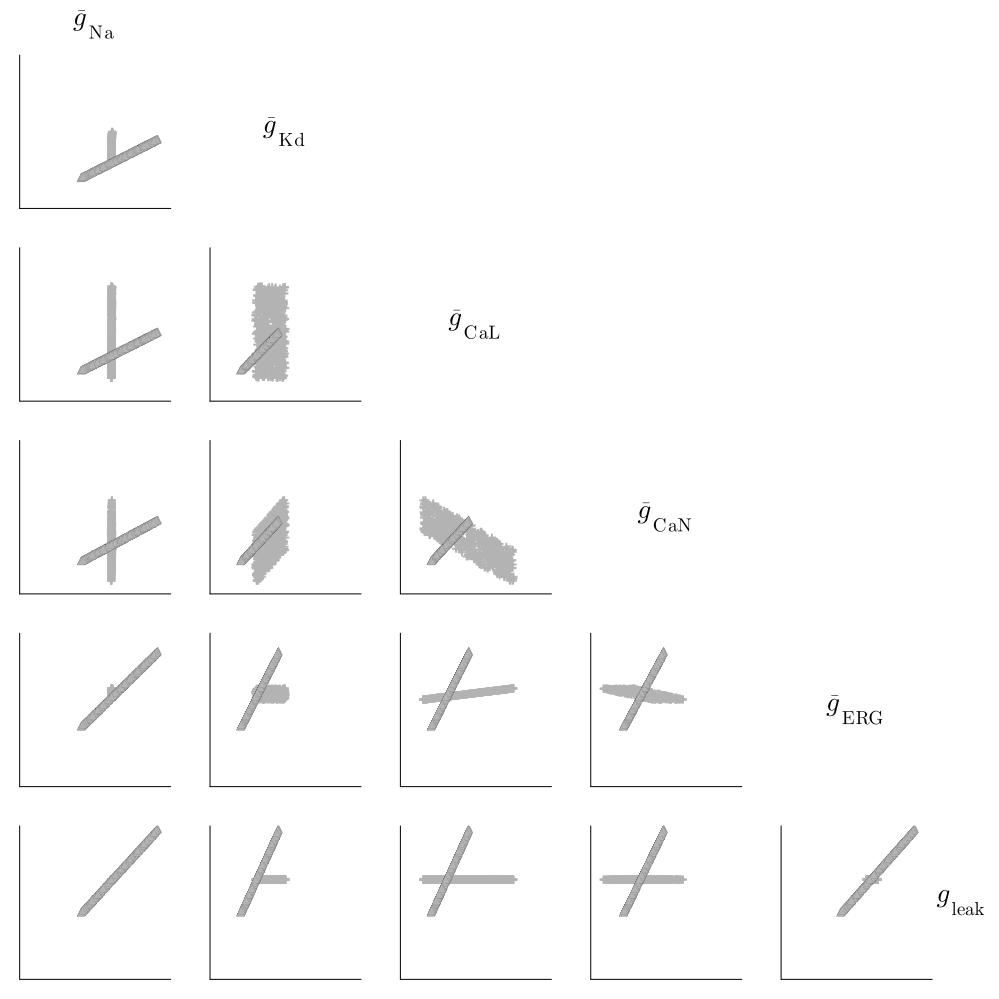

In [92]:
CC = scatter_matrix(g_all_spiking_DIC_wout_NMDA, maxs, :gray70, :cross, 
                    names, flag=3, flag2=1, 
                    g_all2=g_all_spiking_leak_wout_NMDA, m_shape2=:utriangle)
display(CC)
# savefig(CC, "./figures/DA_spiking_matrix_separated.pdf")

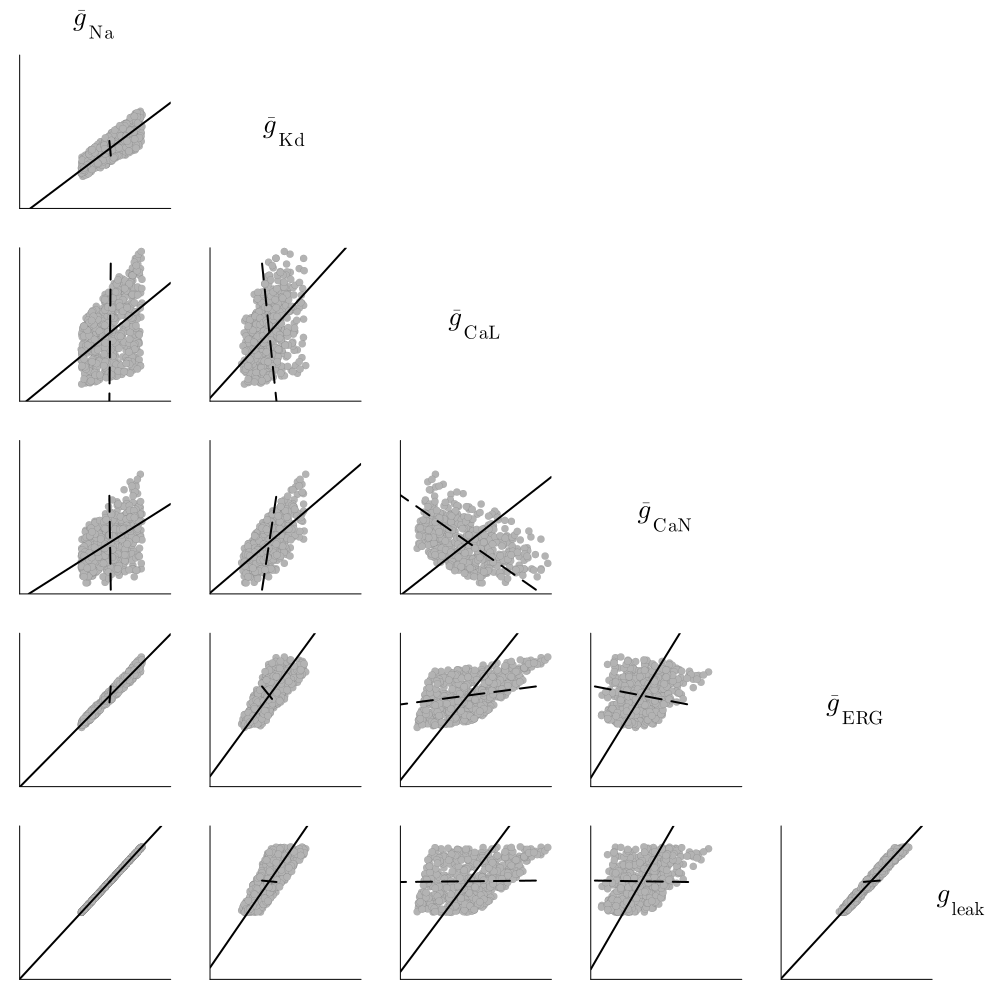

In [93]:
dir_val = eig(eig_spiking_plot.values[end],  eig_spiking_plot.vectors)
CC = scatter_matrix(g_all_spiking_wout_NMDA, maxs, :gray70, :none, 
                    names, flag=2, dir_val=dir_val, 
                    mean_vec=mean_spiking, s1=10, s2=0.8)
display(CC)
# savefig(CC, "./figures/DA_spiking_matrix_PC12.pdf")

# **Old figures**

# **Computing PCA of low frequency tonic spiking neurons and homogeneous scaling using Monte Carlo (Figure 1)**

In [55]:
# Initializing some variables
Na_max = 60
Kd_max = 20
CaL_max = 0.1
CaN_max = 0.3
ERG_max = 0.25
leak_max = 0.02
N = 4e5
VV_maxmax = 58.5
VV_maxmin = 54
VV_minmin = -80.5
VV_minmax = -77.5
f_max = 1.95
f_min = 1.75

g_all_MC = readdlm("./data/g_all_MC.dat");

In [56]:
# Number of ion channels in the DA model
nb_channels = 6

# Initializing some variables
g_all_MC_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_MC_wout_NMDA[:, j] = deepcopy(g_all_MC[:, i])
    j = j + 1
end

# Means on spiking point cloud
mean_MC = zeros(1, nb_channels)
mean!(mean_MC, g_all_MC_wout_NMDA)

# Defining scaling factors and limits for the plots
s1 = 2
s2 = 2

# Normalizing data before applying PCA
g_all_MC_norm = deepcopy(g_all_MC_wout_NMDA)
for i = 1 : nb_channels
    g_all_MC_norm[:, i] = g_all_MC_wout_NMDA[:, i] / std(g_all_MC_wout_NMDA[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC = cov(g_all_MC_norm)
eig_MC = eigen(cov_matrix_MC, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_plot = deepcopy(eig_MC)
for i = 1 : nb_channels
    eig_MC_plot.vectors[i, :] = eig_MC_plot.vectors[i, :] *
                                        std(g_all_MC_wout_NMDA[:, i])
end

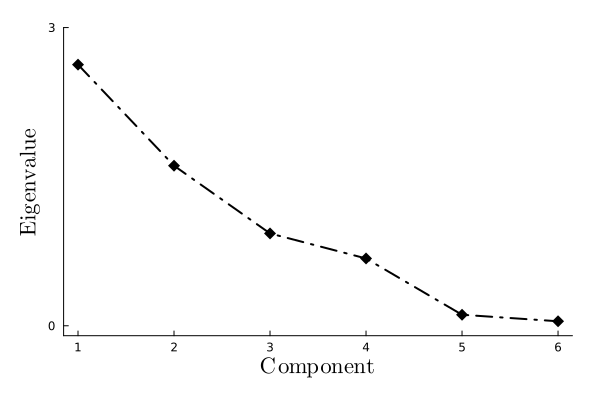

In [57]:
total_var = sum(eig_MC.values)
eig_val_decreasing = reverse(eig_MC.values)

p1a  = plot(eig_val_decreasing, label="", grid=false, yguidefontsize=15, markershape=:diamond, 
            linestyle=:dashdot, xguidefontsize=15, legendfontsize=12, margin=5Plots.mm, 
            xticks=[1, 2, 3, 4, 5, 6], color=:black, markersize=6, linewidth=2, yticks=[0, 3])
ylims!((-0.1, 3))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Eigenvalue}")
display(p1a)
# savefig(p1a, "./figures/DA_MC_scree.pdf")

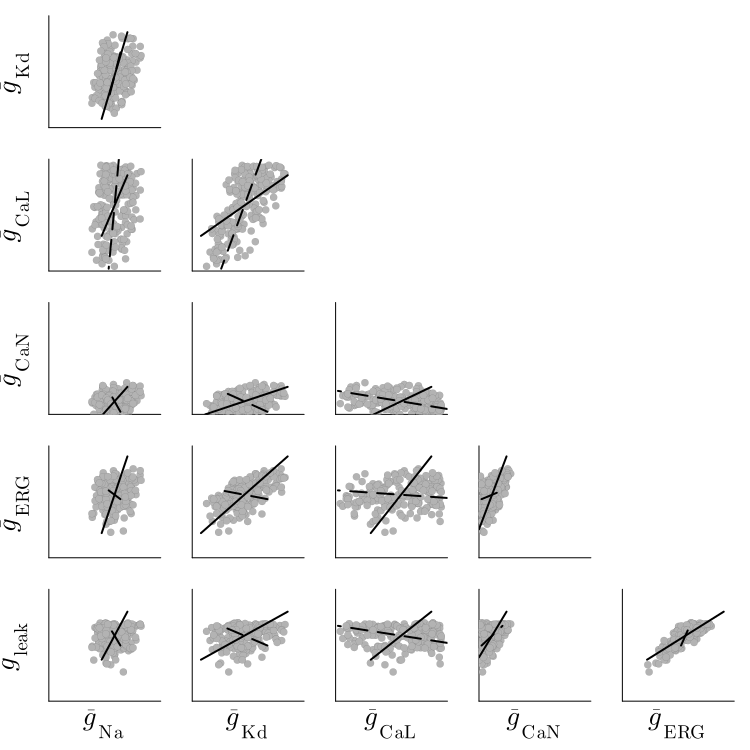

In [58]:
CC1 = scatter_matrix_old(eig_MC_plot, nb_channels, g_all_MC_wout_NMDA, mean_MC, Na_max, 
                     Kd_max, CaL_max, CaN_max, ERG_max, leak_max, s1, s2, :gray70, :none)
display(CC1)
# savefig(CC1, "./figures/DA_MC_matrix.pdf")

In [59]:
# Computing scaling factors for homogeneous scaling
gNa_scaling = mean_MC[1] / mean_MC[6]
gKd_scaling = mean_MC[2] / mean_MC[6]
gCaL_scaling = mean_MC[3] / mean_MC[6]
gCaN_scaling = mean_MC[4] / mean_MC[6]
gERG_scaling = mean_MC[5] / mean_MC[6]

# Computing alignment
scaling = [gNa_scaling, gKd_scaling, gCaL_scaling, gCaN_scaling, gERG_scaling, 1]
for i = 1 : nb_channels
    scaling[i] = scaling[i] / std(g_all_MC_wout_NMDA[:, i])
end
scaling = scaling ./ norm(scaling)

PC1 = eig_MC.vectors[:, nb_channels]
PC1 = PC1 ./ norm(PC1)

alignment = abs(PC1' * scaling)
text = @sprintf "Alignement = %.2f%%" alignment*100
display(text)

"Alignement = 89.15%"

In [60]:
# Computing angles
theta_CaLCaN_leak = atan((gCaN_scaling/CaN_max)/
                         (gCaL_scaling/CaL_max))
theta_CaLCaN = atan((eig_MC_plot.vectors[:, nb_channels][4]/CaN_max)/
                    (eig_MC_plot.vectors[:, nb_channels][3]/CaL_max))

theta_CaNERG_leak = atan((gERG_scaling/ERG_max)/
                         (gCaN_scaling/CaN_max))
theta_CaNERG = atan((eig_MC_plot.vectors[:, nb_channels][5]/ERG_max)/
                    (eig_MC_plot.vectors[:, nb_channels][4]/CaN_max))

theta_KdERG_leak = atan((gERG_scaling/ERG_max)/
                        (gKd_scaling/Kd_max))
theta_KdERG = atan((eig_MC_plot.vectors[:, nb_channels][5]/ERG_max)/
                   (eig_MC_plot.vectors[:, nb_channels][2]/Kd_max))

theta_CaLleak_leak = atan((1/leak_max)/
                          (gCaL_scaling/CaL_max))
theta_CaLleak = atan((eig_MC_plot.vectors[:, nb_channels][6]/leak_max)/
                     (eig_MC_plot.vectors[:, nb_channels][3]/CaL_max));

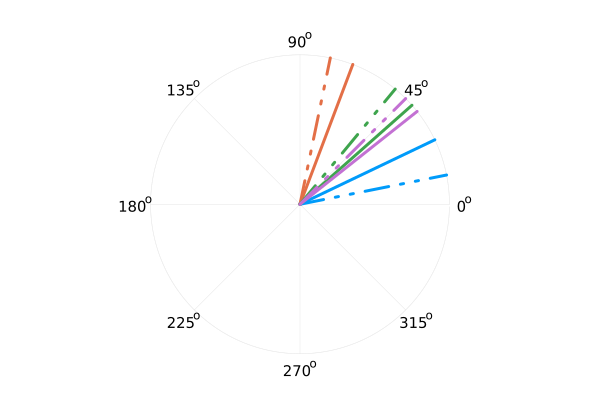

In [61]:
p1b = plot([theta_CaLCaN, theta_CaLCaN], [0, 1], proj=:polar, linewidth=3, label="", yticks=[], 
            yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
            color=1, xtickfontsize=10)
plot!([theta_CaLCaN_leak, theta_CaLCaN_leak], [0, 1], proj=:polar, linewidth=3, label="", 
      color=1, linestyle=:dashdotdot)
plot!([theta_CaNERG, theta_CaNERG], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2)
plot!([theta_CaNERG_leak, theta_CaNERG_leak], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dashdotdot)
plot!([theta_KdERG, theta_KdERG], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3)
plot!([theta_KdERG_leak, theta_KdERG_leak], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dashdotdot)
plot!([theta_CaLleak, theta_CaLleak], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4)
plot!([theta_CaLleak_leak, theta_CaLleak_leak], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dashdotdot)
ylims!(0, 1)
display(p1b)
# savefig(p1b, "./figures/DA_MC_polar_leak.pdf")

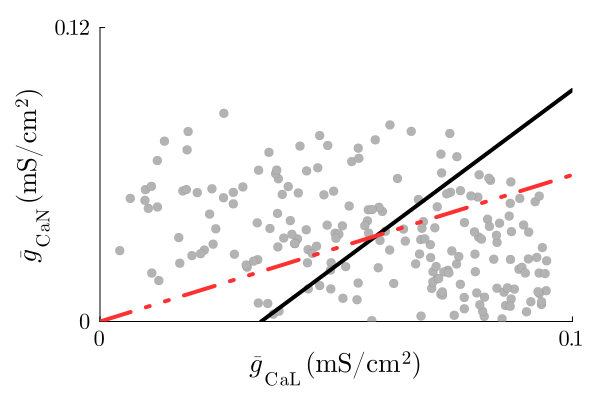

In [62]:
p1c = scatter(g_all_MC[:, 3], g_all_MC[:, 4], label="", color=:gray70, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., markersize=5, yticks=([0, 0.12], [L"0", L"0.12"]), tickfontsize=15, 
              xticks=([0, 0.1], [L"0", L"0.1"]), size=(600, 400))

s1 = 1000
s2 = 2000
plot!([mean_MC[3] - s1*eig_MC_plot.vectors[:, nb_channels][3]*eig_MC_plot.values[nb_channels], 
       mean_MC[3] + s1*eig_MC_plot.vectors[:, nb_channels][3]*eig_MC_plot.values[nb_channels]],
       [mean_MC[4] - s1*eig_MC_plot.vectors[:, nb_channels][4]*eig_MC_plot.values[nb_channels], 
       mean_MC[4] + s1*eig_MC_plot.vectors[:, nb_channels][4]*eig_MC_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_MC[3] - 0.05*gCaL_scaling, 
       mean_MC[3] + 0.05*gCaL_scaling],
       [mean_MC[4] - 0.05*gCaN_scaling, 
       mean_MC[4] + 0.05*gCaN_scaling],
       arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.1))
ylims!((0, 0.12))
display(p1c)
# savefig(p1c, "./figures/neuromod_gCaLCaN_MC.pdf")

# **Computing PCA of low frequency tonic spiking neurons using DICs method (Figure 4)**

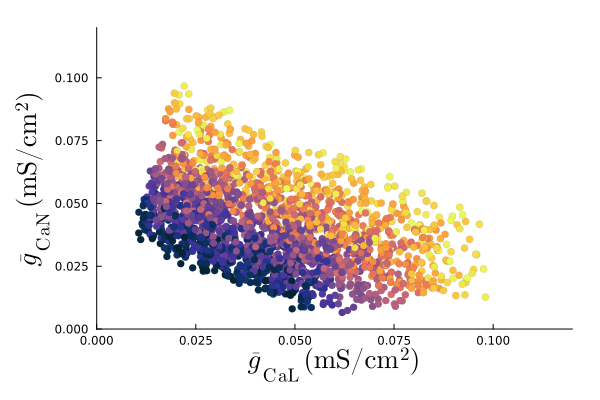

In [63]:
p4c = scatter(g_all_spiking_many[:, 3], g_all_spiking_many[:, 4], label="", 
              zcolor=g_all_spiking_many[:, 7], grid=false, yguidefontsize=18, xguidefontsize=18, 
              legendfontsize=12, margin=5Plots.mm, c=cgrad(:thermal, rev=false), legend=false, 
              markerstrokewidth=0.)

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.12))
ylims!((0, 0.12))
display(p4c)
# savefig(p4c, "./figures/neuromod_many_gCaLCaN_zgleak_spiking.pdf")

# **Computing PCA on homogeneous scaled neurons using Monte Carlo (Figure supp 1)**

In [64]:
g_all_MC_leak = readdlm("./data/g_all_MC_leak.dat")
f_leak = readdlm("./data/f_leak.dat")
Iapp = readdlm("./data/Iapp.dat")
rheobase = readdlm("./data/rheobase.dat")

# Definition of the number of cells in the random set
const ncells = 200;

In [65]:
# Initializing some variables
g_all_MC_leak_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_MC_leak_wout_NMDA[:, j] = deepcopy(g_all_MC_leak[:, i])
    j = j + 1
end

# Means on spiking point cloud
mean_MC_leak = zeros(1, nb_channels)
mean!(mean_MC_leak, g_all_MC_leak_wout_NMDA)

# Defining scaling factors and limits for the plots
s1 = 2
s2 = 2
Na_max = 60
Kd_max = 20
CaL_max = 0.1
CaN_max = 0.3
ERG_max = 0.25
leak_max = 0.02

# Normalizing data before applying PCA
g_all_MC_leak_norm = deepcopy(g_all_MC_leak_wout_NMDA)
for i = 1 : nb_channels
    g_all_MC_leak_norm[:, i] = g_all_MC_leak_wout_NMDA[:, i] / std(g_all_MC_leak_wout_NMDA[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC_leak = cov(g_all_MC_leak_norm)
eig_MC_leak = eigen(cov_matrix_MC_leak, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_leak_plot = deepcopy(eig_MC_leak)
for i = 1 : nb_channels
    eig_MC_leak_plot.vectors[i, :] = eig_MC_leak_plot.vectors[i, :] *
                                        std(g_all_MC_leak_wout_NMDA[:, i])
end

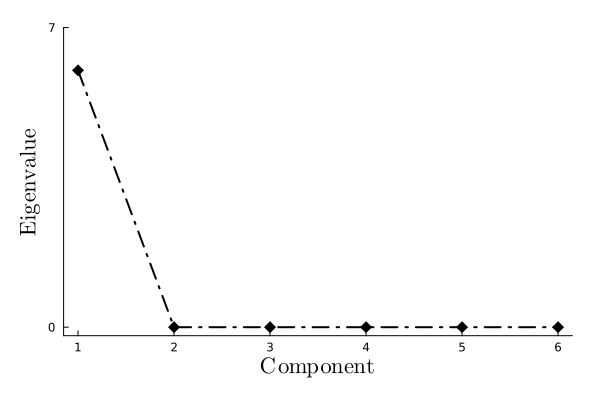

In [66]:
total_var = sum(eig_MC_leak.values)
eig_val_decreasing = reverse(eig_MC_leak.values)
ps1a = plot(eig_val_decreasing, label="", grid=false, yguidefontsize=15, markershape=:diamond, 
            linestyle=:dashdot, xguidefontsize=15, legendfontsize=12, margin=5Plots.mm, 
            xticks=[1, 2, 3, 4, 5, 6], color=:black, markersize=6, linewidth=2, yticks=[0, 7])
ylims!((-0.2, 7))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Eigenvalue}")
display(ps1a)
# savefig(ps1a, "./figures/DA_MC_scree_leak.pdf")

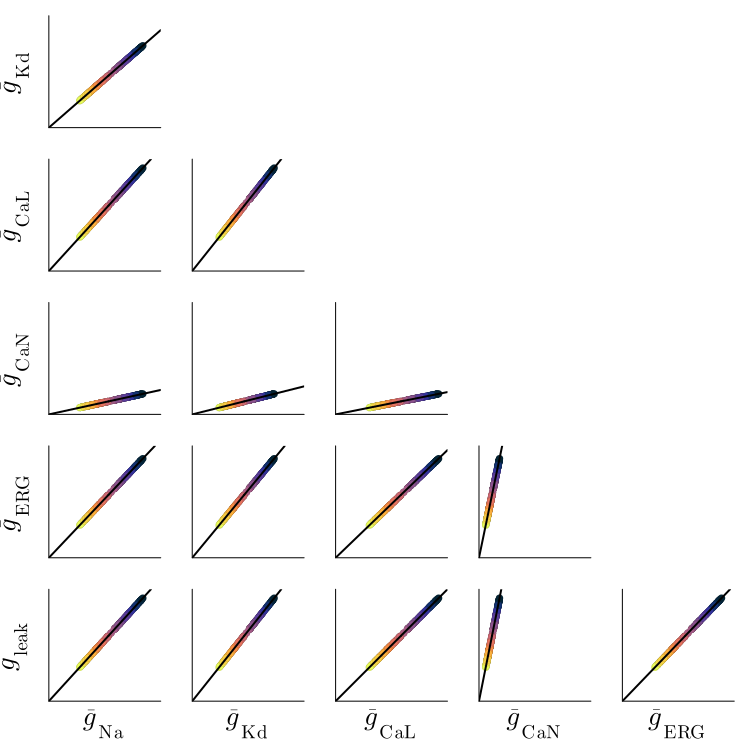

In [67]:
CCs1 = scatter_matrix_zcolor(eig_MC_leak_plot, nb_channels, g_all_MC_leak_wout_NMDA, mean_MC, 
                             Na_max*1.1, Kd_max, CaL_max, CaN_max, ERG_max, leak_max, s1, 0, 
                             rheobase, :none)
display(CCs1)
# savefig(CCs1, "./figures/DA_MC_matrix_leak.pdf")

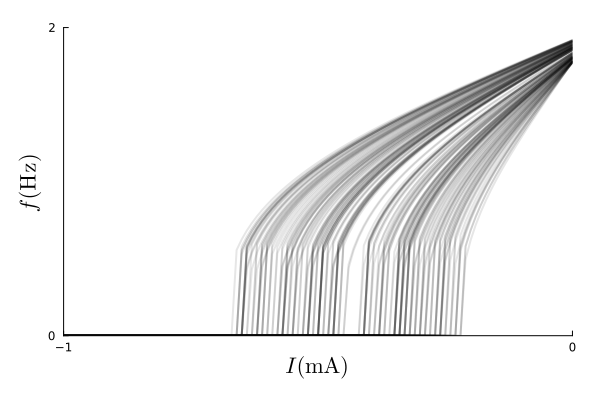

In [68]:
# Plotting the I f curves
ps1b = plot()
for i = 1 : ncells
    plot!(Iapp, f_leak[:, i], label="", grid=false, yguidefontsize=15, xguidefontsize=15, 
          legendfontsize=12, margin=5Plots.mm, color=:black, alpha=0.1, linewidth=2, 
          xticks=[-1, 0], yticks=[0, 2])
end
xlabel!(L"I\,\mathrm{(mA)}")
ylabel!(L"f\,\mathrm{(Hz)}")
xlims!((-1, 0))
ylims!((0, 2))
display(ps1b)
# savefig(ps1b, "./figures/simu_DA_MC_hyper_leak.pdf")

# **Plotting low frequency tonic spiking neurons generated using the DICs method (Figure supp 2)**

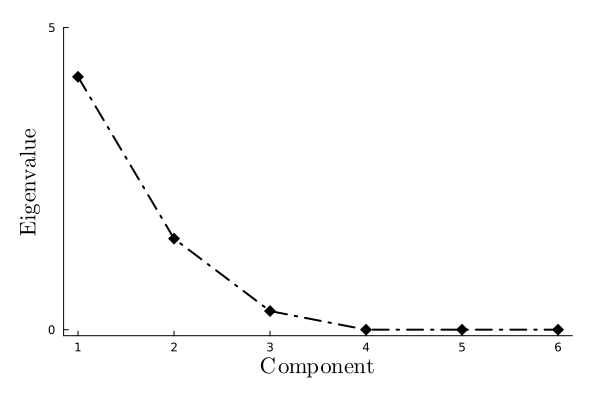

In [69]:
total_var = sum(eig_spiking.values)
eig_val_decreasing = reverse(eig_spiking.values)

ps2 = plot(eig_val_decreasing, label="", grid=false, yguidefontsize=15, markershape=:diamond, 
           linestyle=:dashdot, xguidefontsize=15, legendfontsize=12, margin=5Plots.mm, 
           xticks=[1, 2, 3, 4, 5, 6], color=:black, markersize=6, linewidth=2, yticks=[0, 5])
ylims!((-0.1, 5))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Eigenvalue}")
display(ps2)
# savefig(ps2, "./figures/DA_PCA_spiking_scree.pdf")

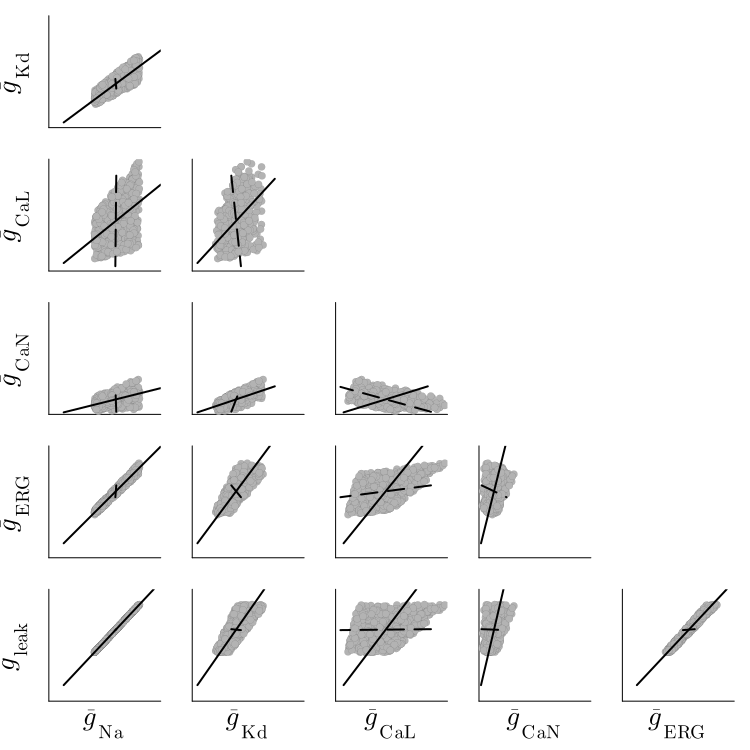

In [70]:
CCs2 = scatter_matrix_old(eig_spiking_plot, nb_channels, g_all_spiking_wout_NMDA, mean_spiking, Na_max, 
                      Kd_max, CaL_max, CaN_max, ERG_max, leak_max, s1, s2, :gray70, :none)
display(CCs2)
# savefig(CCs2, "./figures/DA_PCA_spiking_matrix.pdf")

# **Computing PCA on low frequency tonic spiking neurons generated using the DICs method, property separated (Figure supp 3&4)**

In [71]:
# Definition of the number of cells in the random set
const ncells = 500;

In [72]:
# Initializing some variables
g_all_spiking_leak_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_spiking_leak_wout_NMDA[:, j] = deepcopy(g_all_spiking_leak[:, i])
    j = j + 1
end

# Means on spiking point cloud
mean_spiking_leak = zeros(1, nb_channels)
mean!(mean_spiking_leak, g_all_spiking_leak_wout_NMDA)

# Defining scaling factors and limits for the plots
s1 = 2
s2 = 2
Na_max = 60
Kd_max = 20
CaL_max = 0.1
CaN_max = 0.3
ERG_max = 0.25
leak_max = 0.02

# Normalizing data before applying PCA
g_all_spiking_leak_norm = deepcopy(g_all_spiking_leak_wout_NMDA)
for i = 1 : nb_channels
    g_all_spiking_leak_norm[:, i] = g_all_spiking_leak_wout_NMDA[:, i] / 
                                    std(g_all_spiking_leak_wout_NMDA[:, i])
end

# PCA on spiking point cloud
cov_matrix_spiking_leak = cov(g_all_spiking_leak_norm)
eig_spiking_leak = eigen(cov_matrix_spiking_leak, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_spiking_leak_plot = deepcopy(eig_spiking_leak)
for i = 1 : nb_channels
    eig_spiking_leak_plot.vectors[i, :] = eig_spiking_leak_plot.vectors[i, :] *
                                        std(g_all_spiking_leak_wout_NMDA[:, i])
end

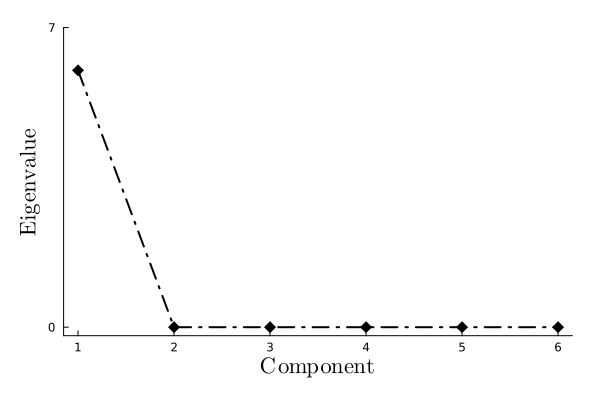

In [73]:
total_var = sum(eig_spiking_leak.values)
eig_val_decreasing = reverse(eig_spiking_leak.values)
ps3 = plot(eig_val_decreasing, label="", grid=false, yguidefontsize=15, markershape=:diamond, 
           linestyle=:dashdot, xguidefontsize=15, legendfontsize=12, margin=5Plots.mm, 
           xticks=[1, 2, 3, 4, 5, 6], color=:black, markersize=6, linewidth=2, yticks=[0, 7])
ylims!((-0.2, 7))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Eigenvalue}")
display(ps3)
# savefig(ps3, "./figures/DA_PCA_spiking_scree_leak.pdf")

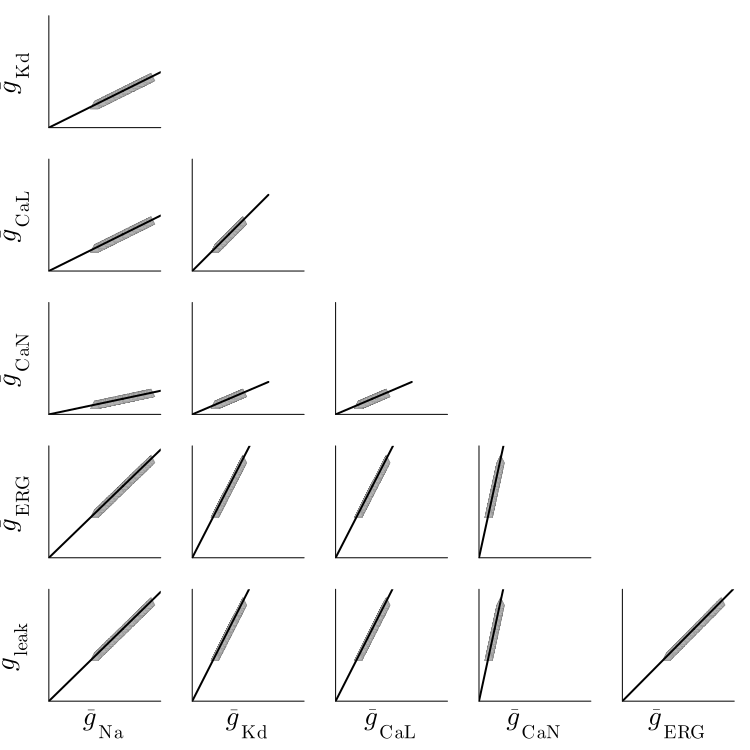

In [74]:
CCs3 = scatter_matrix_old(eig_spiking_leak_plot, nb_channels, g_all_spiking_leak_wout_NMDA, 
                      mean_spiking_leak, Na_max, Kd_max, CaL_max, CaN_max, ERG_max, leak_max*1.1, 
                      s1, 0, :gray70, :utriangle)
display(CCs3)
# savefig(CCs3, "./figures/DA_PCA_spiking_leak_matrix.pdf")

In [75]:
# Initializing some variables
g_all_spiking_DIC_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_spiking_DIC_wout_NMDA[:, j] = deepcopy(g_all_spiking_DIC[:, i])
    j = j + 1
end

# Means on spiking point cloud
mean_spiking_DIC = zeros(1, nb_channels)
mean!(mean_spiking_DIC, g_all_spiking_DIC_wout_NMDA)

# Defining scaling factors and limits for the plots
s1 = 2
s2 = 2
Na_max = 60
Kd_max = 20
CaL_max = 0.1
CaN_max = 0.3
ERG_max = 0.25
leak_max = 0.02

# Normalizing data before applying PCA
g_all_spiking_DIC_norm = deepcopy(g_all_spiking_DIC_wout_NMDA)
for i = 1 : nb_channels
    g_all_spiking_DIC_norm[:, i] = g_all_spiking_DIC_wout_NMDA[:, i] / 
                                    std(g_all_spiking_DIC_wout_NMDA[:, i])
end

# PCA on spiking point cloud
cov_matrix_spiking_DIC = cov(g_all_spiking_DIC_norm)
eig_spiking_DIC = eigen(cov_matrix_spiking_DIC, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_spiking_DIC_plot = deepcopy(eig_spiking_DIC)
for i = 1 : nb_channels
    eig_spiking_DIC_plot.vectors[i, :] = eig_spiking_DIC_plot.vectors[i, :] *
                                        std(g_all_spiking_DIC_wout_NMDA[:, i])
end

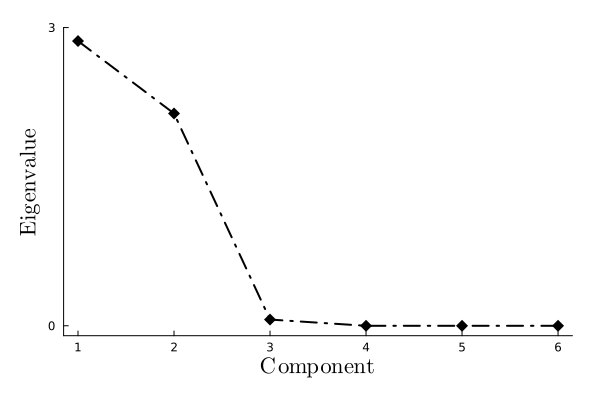

In [76]:
total_var = sum(eig_spiking_DIC.values)
eig_val_decreasing = reverse(eig_spiking_DIC.values)
ps4 = plot(eig_val_decreasing, label="", grid=false, yguidefontsize=15, markershape=:diamond, 
           linestyle=:dashdot, xguidefontsize=15, legendfontsize=12, margin=5Plots.mm, 
           xticks=[1, 2, 3, 4, 5, 6], color=:black, markersize=6, linewidth=2, yticks=[0, 3])
ylims!((-0.1, 3))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Eigenvalue}")
display(ps4)
# savefig(ps4, "./figures/DA_PCA_spiking_scree_DIC.pdf")

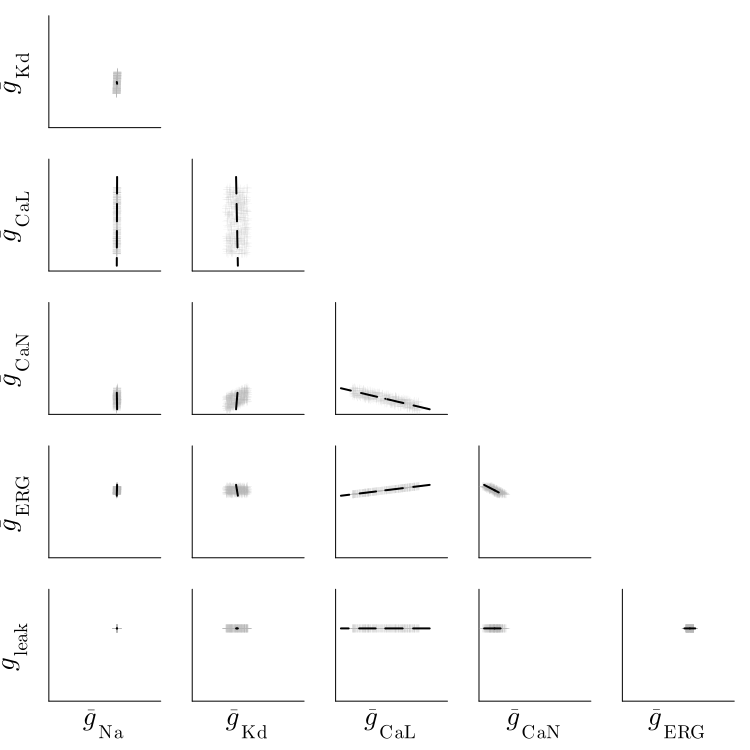

In [77]:
eig_spiking_DIC_plot.vectors[:, nb_channels-1] = eig_spiking_DIC_plot.vectors[:, nb_channels]
eig_spiking_DIC_plot.values[nb_channels-1]=eig_spiking_DIC_plot.values[nb_channels]
CCs4 = scatter_matrix_old(eig_spiking_DIC_plot, nb_channels, g_all_spiking_DIC_wout_NMDA, 
                      mean_spiking_DIC, Na_max, Kd_max, CaL_max, CaN_max, ERG_max, leak_max, 
                      0, s2/1.5, :gray70, :cross)
display(CCs4)
# savefig(CCs4, "./figures/DA_PCA_spiking_DIC_matrix.pdf")

# **Plotting low frequency tonic spiking neurons generated using the DICs method and highlighting Rin (Figure supp 5)**

In [78]:
# Defining threshold voltage
Vth = -55.5

# Definition of the number of cells in the random set
const ncells = 2000;

In [79]:
# Initializing some variables
Rin_spiking_many = zeros(ncells)

# Looping over all points to compute input resistance at threshold voltage
for i = 1 : ncells
    Rin_spiking_many[i] = (g_all_spiking_many[i, 1]*m_inf(Vth)^3*h_inf(Vth) + 
                           g_all_spiking_many[i, 2]*n_inf(Vth)^3 + 
                           g_all_spiking_many[i, 3]*mCaL_inf(Vth)^2 + 
                           g_all_spiking_many[i, 4]*mCaN_inf(Vth) +
                           g_all_spiking_many[i, 5]*o_inf(Vth) +
                           g_all_spiking_many[i, 6]*NMDA_inf(Vth) +
                           g_all_spiking_many[i, 7])^(-1)
end

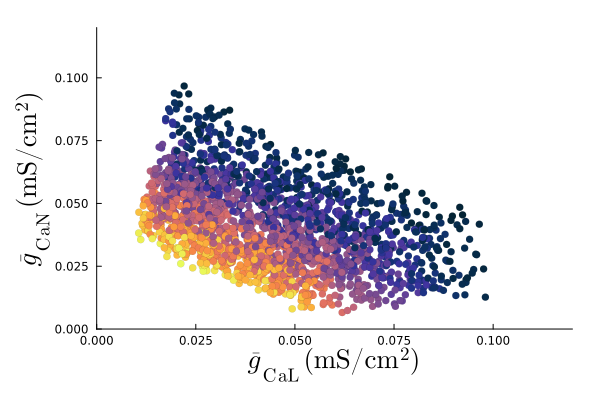

In [80]:
ps5 = scatter(g_all_spiking_many[:, 3], g_all_spiking_many[:, 4], label="", 
              zcolor=Rin_spiking_many, grid=false, yguidefontsize=18, xguidefontsize=18, 
              legendfontsize=12, margin=5Plots.mm, c=cgrad(:thermal, rev=false), legend=false, 
              markerstrokewidth=0.)

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.12))
ylims!((0, 0.12))
display(ps5)
# savefig(ps5, "./figures/neuromod_many_gCaLCaN_zRin_spiking.pdf")

# **Ion current at different voltages**

In [85]:
const ncells = 200

nb_channels = 6
g_all_MC = readdlm("./data/g_all_MC.dat")

# Initializing some variables
g_all_MC_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_MC_wout_NMDA[:, j] = deepcopy(g_all_MC[:, i])
    j = j + 1
end
gmeans = mean(g_all_MC, dims=1)

VVmin = -60.
VVmin_str = latexstring("$VVmin")
VVmax = -54
VVmax_str = latexstring("$VVmax")
V_gv = VVmin : 0.01 : VVmax;

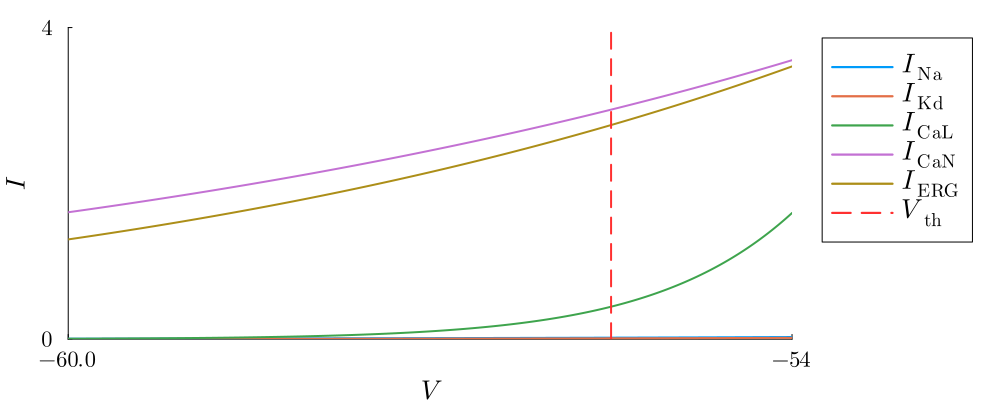

In [86]:
Na_current = abs.(m_inf.(V_gv).^3 .* h_inf.(V_gv) .* (V_gv.-VNa))
Kd_current = abs.(n_inf.(V_gv).^3 .* (V_gv.-VK))
CaL_current = abs.(mCaL_inf.(V_gv).^2 .* (V_gv.-VCa))
CaN_current = abs.(mCaN_inf.(V_gv) .* (V_gv.-VCa))
ERG_current = abs.(o_inf.(V_gv) .* (V_gv.-VK))
y_max = max(maximum(Na_current), maximum(Kd_current), maximum(CaL_current), 
            maximum(CaN_current), maximum(ERG_current))
y_max = Int(round(y_max, RoundUp))
y_max_str = latexstring("$y_max")
y_min = min(minimum(Na_current), minimum(Kd_current), minimum(CaL_current), 
            minimum(CaN_current), minimum(ERG_current))
y_min = Int(round(y_min, RoundDown))
y_min_str = latexstring("$y_min")

p0 = plot(V_gv, Na_current, grid=false, label=L"I_\mathrm{Na}", guidefontsize=18, legendfontsize=18, 
    margin=5Plots.mm, xticks=([VVmin, VVmax], [VVmin_str, VVmax_str]), 
    yticks=([y_min, y_max], [y_min_str, y_max_str]), linewidth=2, tickfontsize=15, 
    size=(1000, 400), legend=:outertopright, xlims=(VVmin, VVmax), ylims=(y_min, y_max))
plot!(V_gv, Kd_current, label=L"I_\mathrm{Kd}", linewidth=2)
plot!(V_gv, CaL_current, label=L"I_\mathrm{CaL}", linewidth=2)
plot!(V_gv, CaN_current, label=L"I_\mathrm{CaN}", linewidth=2)
plot!(V_gv, ERG_current, label=L"I_\mathrm{ERG}", linewidth=2)
vline!([-55.5], linewidth=2, color=:firebrick1, linestyle=:dash, label=L"V_\mathrm{th}")
xlabel!(L"V")
ylabel!(L"I")
# savefig(p0, "DA_current_nog.pdf")

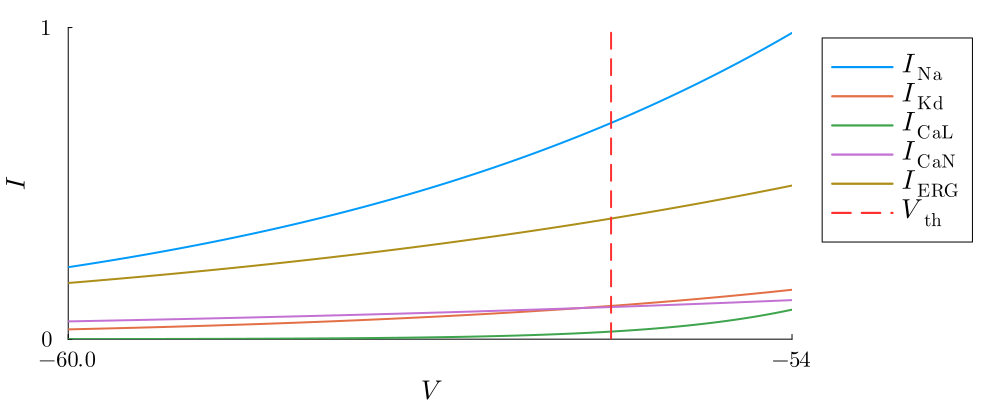

In [87]:
Na_current = abs.(gmeans[1] .* m_inf.(V_gv).^3 .* h_inf.(V_gv) .* (V_gv.-VNa))
Kd_current = abs.(gmeans[2] .* n_inf.(V_gv).^3 .* (V_gv.-VK))
CaL_current = abs.(gmeans[3] .* mCaL_inf.(V_gv).^2 .* (V_gv.-VCa))
CaN_current = abs.(gmeans[4] .* mCaN_inf.(V_gv) .* (V_gv.-VCa))
ERG_current = abs.(gmeans[5] .* o_inf.(V_gv) .* (V_gv.-VK))
y_max = max(maximum(Na_current), maximum(Kd_current), maximum(CaL_current), 
            maximum(CaN_current), maximum(ERG_current))
y_max = Int(round(y_max, RoundUp))
y_max_str = latexstring("$y_max")
y_min = min(minimum(Na_current), minimum(Kd_current), minimum(CaL_current), 
            minimum(CaN_current), minimum(ERG_current))
y_min = Int(round(y_min, RoundDown))
y_min_str = latexstring("$y_min")

p0 = plot(V_gv, Na_current, grid=false, label=L"I_\mathrm{Na}", guidefontsize=18, legendfontsize=18, 
    margin=5Plots.mm, xticks=([VVmin, VVmax], [VVmin_str, VVmax_str]), 
    yticks=([y_min, y_max], [y_min_str, y_max_str]), linewidth=2, tickfontsize=15, 
    size=(1000, 400), legend=:outertopright, xlims=(VVmin, VVmax), ylims=(y_min, y_max))
plot!(V_gv, Kd_current, label=L"I_\mathrm{Kd}", linewidth=2)
plot!(V_gv, CaL_current, label=L"I_\mathrm{CaL}", linewidth=2)
plot!(V_gv, CaN_current, label=L"I_\mathrm{CaN}", linewidth=2)
plot!(V_gv, ERG_current, label=L"I_\mathrm{ERG}", linewidth=2)
vline!([-55.5], linewidth=2, color=:firebrick1, linestyle=:dash, label=L"V_\mathrm{th}")
xlabel!(L"V")
ylabel!(L"I")
# savefig(p0, "DA_current.pdf")

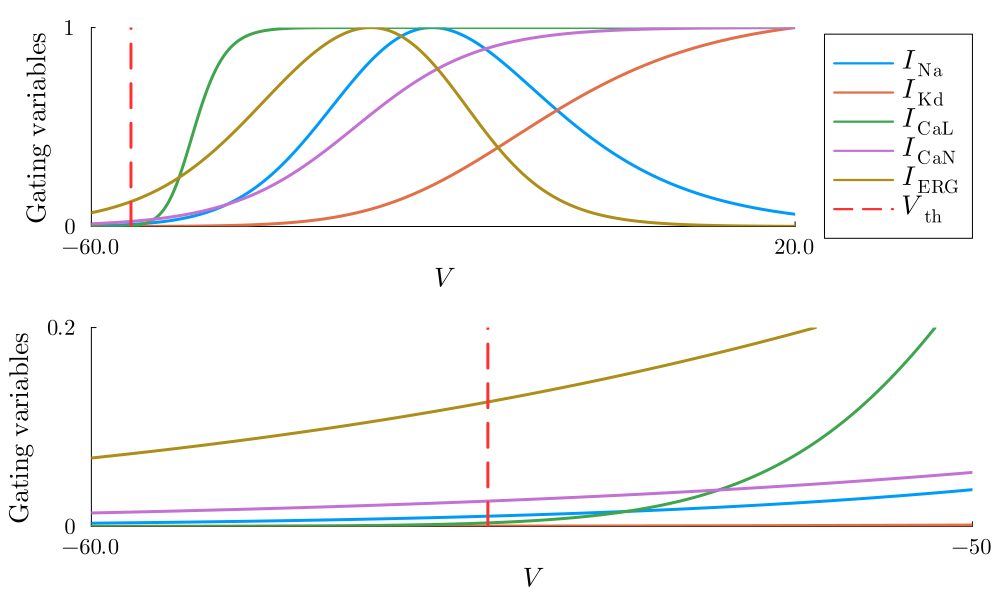

In [88]:
VVmin = -60.
VVmin_str = latexstring("$VVmin")
VVmax = 20.
VVmax_str = latexstring("$VVmax")
V_gv = VVmin : 0.01 : VVmax
Na_current = m_inf.(V_gv).^3 .* h_inf.(V_gv)
Na_current = Na_current / maximum(Na_current)
Kd_current = n_inf.(V_gv).^3
Kd_current = Kd_current / maximum(Kd_current)
CaL_current = mCaL_inf.(V_gv).^2
CaL_current = CaL_current / maximum(CaL_current)
CaN_current = mCaN_inf.(V_gv)
CaN_current = CaN_current / maximum(CaN_current)
ERG_current = o_inf.(V_gv)
ERG_current = ERG_current / maximum(ERG_current)

y_max = max(maximum(Na_current), maximum(Kd_current), maximum(CaL_current), 
            maximum(CaN_current), maximum(ERG_current))
y_max = Int(round(y_max, RoundUp))
y_max_str = latexstring("$y_max")
y_min = min(minimum(Na_current), minimum(Kd_current), minimum(CaL_current), 
            minimum(CaN_current), minimum(ERG_current))
y_min = Int(round(y_min, RoundDown))
y_min_str = latexstring("$y_min")

p0 = plot(V_gv, Na_current, grid=false, label=L"I_\mathrm{Na}", guidefontsize=18, legendfontsize=18, 
    margin=5Plots.mm, xticks=([VVmin, VVmax], [VVmin_str, VVmax_str]), 
    yticks=([y_min, y_max], [y_min_str, y_max_str]), linewidth=3, tickfontsize=15, 
    size=(1000, 400), legend=:outertopright, xlims=(VVmin, VVmax), ylims=(y_min, y_max))
plot!(V_gv, Kd_current, label=L"I_\mathrm{Kd}", linewidth=3)
plot!(V_gv, CaL_current, label=L"I_\mathrm{CaL}", linewidth=3)
plot!(V_gv, CaN_current, label=L"I_\mathrm{CaN}", linewidth=3)
plot!(V_gv, ERG_current, label=L"I_\mathrm{ERG}", linewidth=3)
vline!([-55.5], linewidth=3, color=:firebrick1, linestyle=:dash, label=L"V_\mathrm{th}")
xlabel!(L"V")
ylabel!(L"\mathrm{Gating}\,\, \mathrm{variables}")
p1 = plot(V_gv, Na_current, grid=false, label=L"I_\mathrm{Na}", guidefontsize=18, legendfontsize=18, 
    margin=5Plots.mm, xticks=([VVmin, -50.], [VVmin_str, L"-50"]), 
    yticks=([y_min, 0.2], [y_min_str, L"0.2"]), linewidth=3, tickfontsize=15, 
    size=(1000, 400), legend=false, xlims=(VVmin, -50.), ylims=(y_min, 0.2))
plot!(V_gv, Kd_current, label=L"I_\mathrm{Kd}", linewidth=3)
plot!(V_gv, CaL_current, label=L"I_\mathrm{CaL}", linewidth=3)
plot!(V_gv, CaN_current, label=L"I_\mathrm{CaN}", linewidth=3)
plot!(V_gv, ERG_current, label=L"I_\mathrm{ERG}", linewidth=3)
vline!([-55.5], linewidth=3, color=:firebrick1, linestyle=:dash, label=L"V_\mathrm{th}")
xlabel!(L"V")
ylabel!(L"\mathrm{Gating}\,\, \mathrm{variables}")
CC = plot(p0, p1, layout=(2, 1), size=(1000, 600))
# savefig(CC, "DA_current_zoomed.pdf")

# New supplementary figure

In [23]:
# Initializing some variables
freq = zeros(ncells)

@showprogress 1 "Computing..." for i = 1 : ncells
    # Retrieving maximal conductances from what had been computed
    (gNa, gKd, gCaL, gCaN, gERG, gNMDA, gleak) = g_all_spiking[i, :]

    # Parameter vector for simulations
    p = [0., gNa, gKd, gCaL, gCaN, gERG, gNMDA, gleak, C]

    # Initial conditions
    V0 = -90.
    x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

    # Simulation
    prob = ODEProblem(DA_ODE, x0, tspan, p) # Describing the problem
    sol = solve(prob, saveat=0.1) # Solving the problem

    # Saving results
    VV = sol[1, 50001:end]
    tt = sol.t[50001:end]

    # Computing spiking frequency
    if tt[end] != Tfinal
        freq[i] = 0.
    else
        freq[i] = extract_frequency(VV, tt)
        if isnan(freq[i])
            freq[k, i] = 0.
        end
    end
end

Computing... 100%|███████████████████████████████████████| Time: 0:00:17


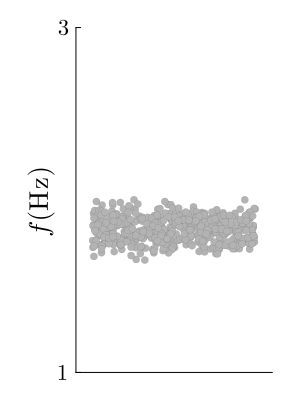

In [35]:
Random.seed!(2022)
pS = scatter(rand(ncells), freq, label="", color=:gray70, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., yticks=([1, 3], [L"1", L"3"]), tickfontsize=15, 
              xticks=false, size=(300, 400))

ylabel!(L"f\,\mathrm{(Hz)}")
xlims!((-0.1, 1.1))
ylims!((1, 3))
display(pS)
# savefig(pS, "DA_freq_spiking.pdf")